### Kaggle code 탐색

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from scipy.special import inv_boxcox

In [121]:
df = pd.read_csv('data/car data.csv')

In [122]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


"Selling_Price" will be the dependent variable and the rest of the variables will be considered as independent variables.

In [3]:
df

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0


In [4]:
df.describe(include='number')

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [5]:
df.describe(include='object')

,Car_Name,Fuel_Type,Seller_Type,Transmission
count,301,301,301,301
unique,98,3,2,2
top,city,Petrol,Dealer,Manual
freq,26,239,195,261


Step 4.1: Feature Subset Selection

In [6]:
df['Car_Name'].nunique()

98

In [7]:
df.drop('Car_Name', axis=1, inplace=True)


In [8]:
df.insert(0, "Age", df["Year"].max()+1-df["Year"] )
df.drop('Year', axis=1, inplace=True)
df.head()

,Age,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,6,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,8,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,5,4.60,6.87,42450,Diesel,Dealer,Manual,0


Step 4.3: Outlier Detection


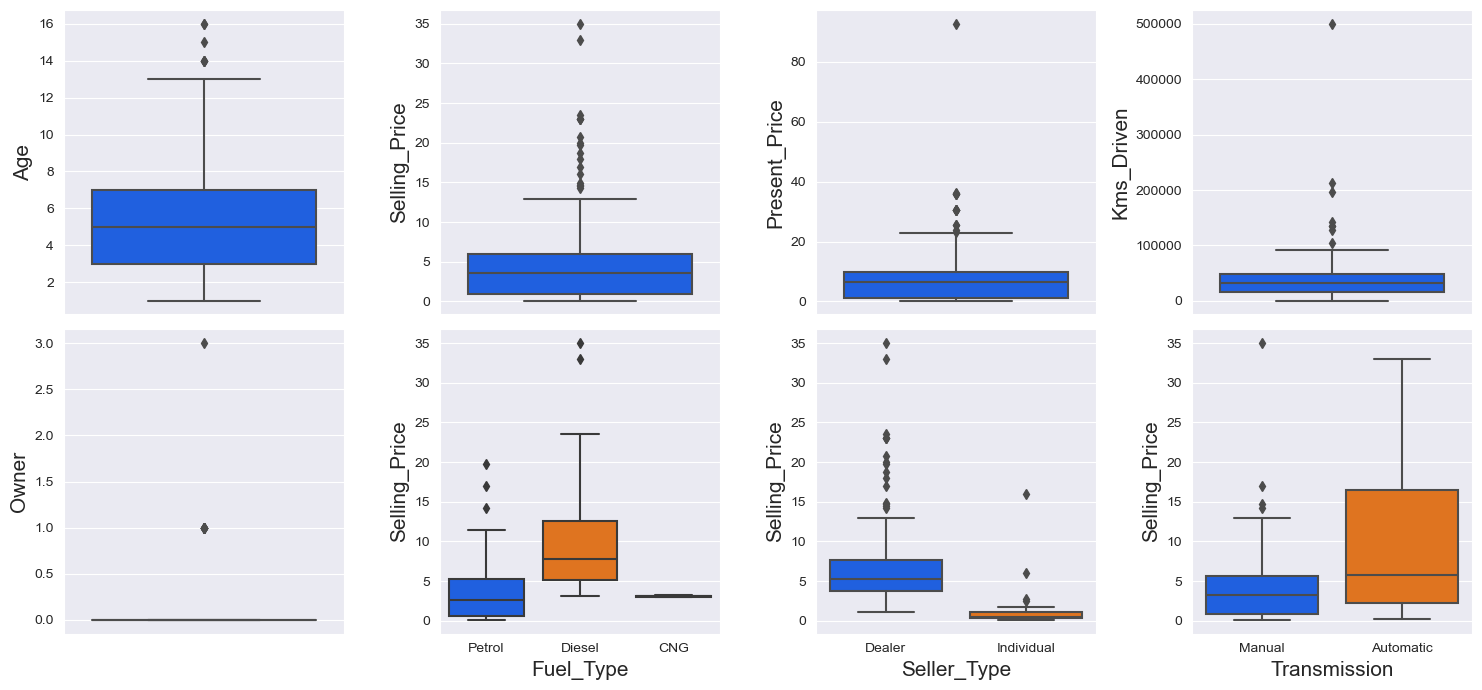

In [9]:
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))

OrderedCols = np.concatenate([df.select_dtypes(exclude='object').columns.values, 
                              df.select_dtypes(include='object').columns.values])

fig, ax = plt.subplots(2, 4, figsize=(15,7),dpi=100)

for i,col in enumerate(OrderedCols):
    x = i//4
    y = i%4
    if i<5:
        sns.boxplot(data=df, y=col, ax=ax[x,y])
        ax[x,y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, x=col, y='Selling_Price', ax=ax[x,y])
        ax[x,y].xaxis.label.set_size(15)
        ax[x,y].yaxis.label.set_size(15)

plt.tight_layout()    
plt.show()

As can be seen from the boxplots above, there are outliers in the dataset. We will identify the outliers based on the InterQuartile Range rule:

In [10]:
outliers_indexes = []
target = 'Selling_Price'

for col in df.select_dtypes(include='object').columns:
    for cat in df[col].unique():
        df1 = df[df[col] == cat]
        q1 = df1[target].quantile(0.25)
        q3 = df1[target].quantile(0.75)
        iqr = q3-q1
        maximum = q3 + (1.5 * iqr)
        minimum = q1 - (1.5 * iqr)
        outlier_samples = df1[(df1[target] < minimum) | (df1[target] > maximum)]
        outliers_indexes.extend(outlier_samples.index.tolist())
        
        
for col in df.select_dtypes(exclude='object').columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    maximum = q3 + (1.5 * iqr)
    minimum = q1 - (1.5 * iqr)
    outlier_samples = df[(df[col] < minimum) | (df[col] > maximum)]
    outliers_indexes.extend(outlier_samples.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('{} outliers were identified, whose indices are:\n\n{}'.format(len(outliers_indexes), outliers_indexes))

38 outliers were identified, whose indices are:

[27, 37, 39, 50, 51, 52, 53, 54, 179, 184, 58, 59, 189, 62, 63, 64, 191, 66, 192, 196, 69, 193, 198, 201, 77, 205, 79, 80, 82, 84, 85, 86, 92, 93, 96, 97, 106, 241]


It is not acceptable to drop an observation just because it is an outlier. They can be legitimate observations and it’s important to investigate the nature of the outlier before deciding whether to drop it or not. We are allowed to delete outliers in two cases:

Outlier is due to incorrectly entered or measured data
Outlier creates a significant association
---
이상치는 정당한 관측치 일 수 있음. 무조건 삭제하는 것은 바람직하지 못함

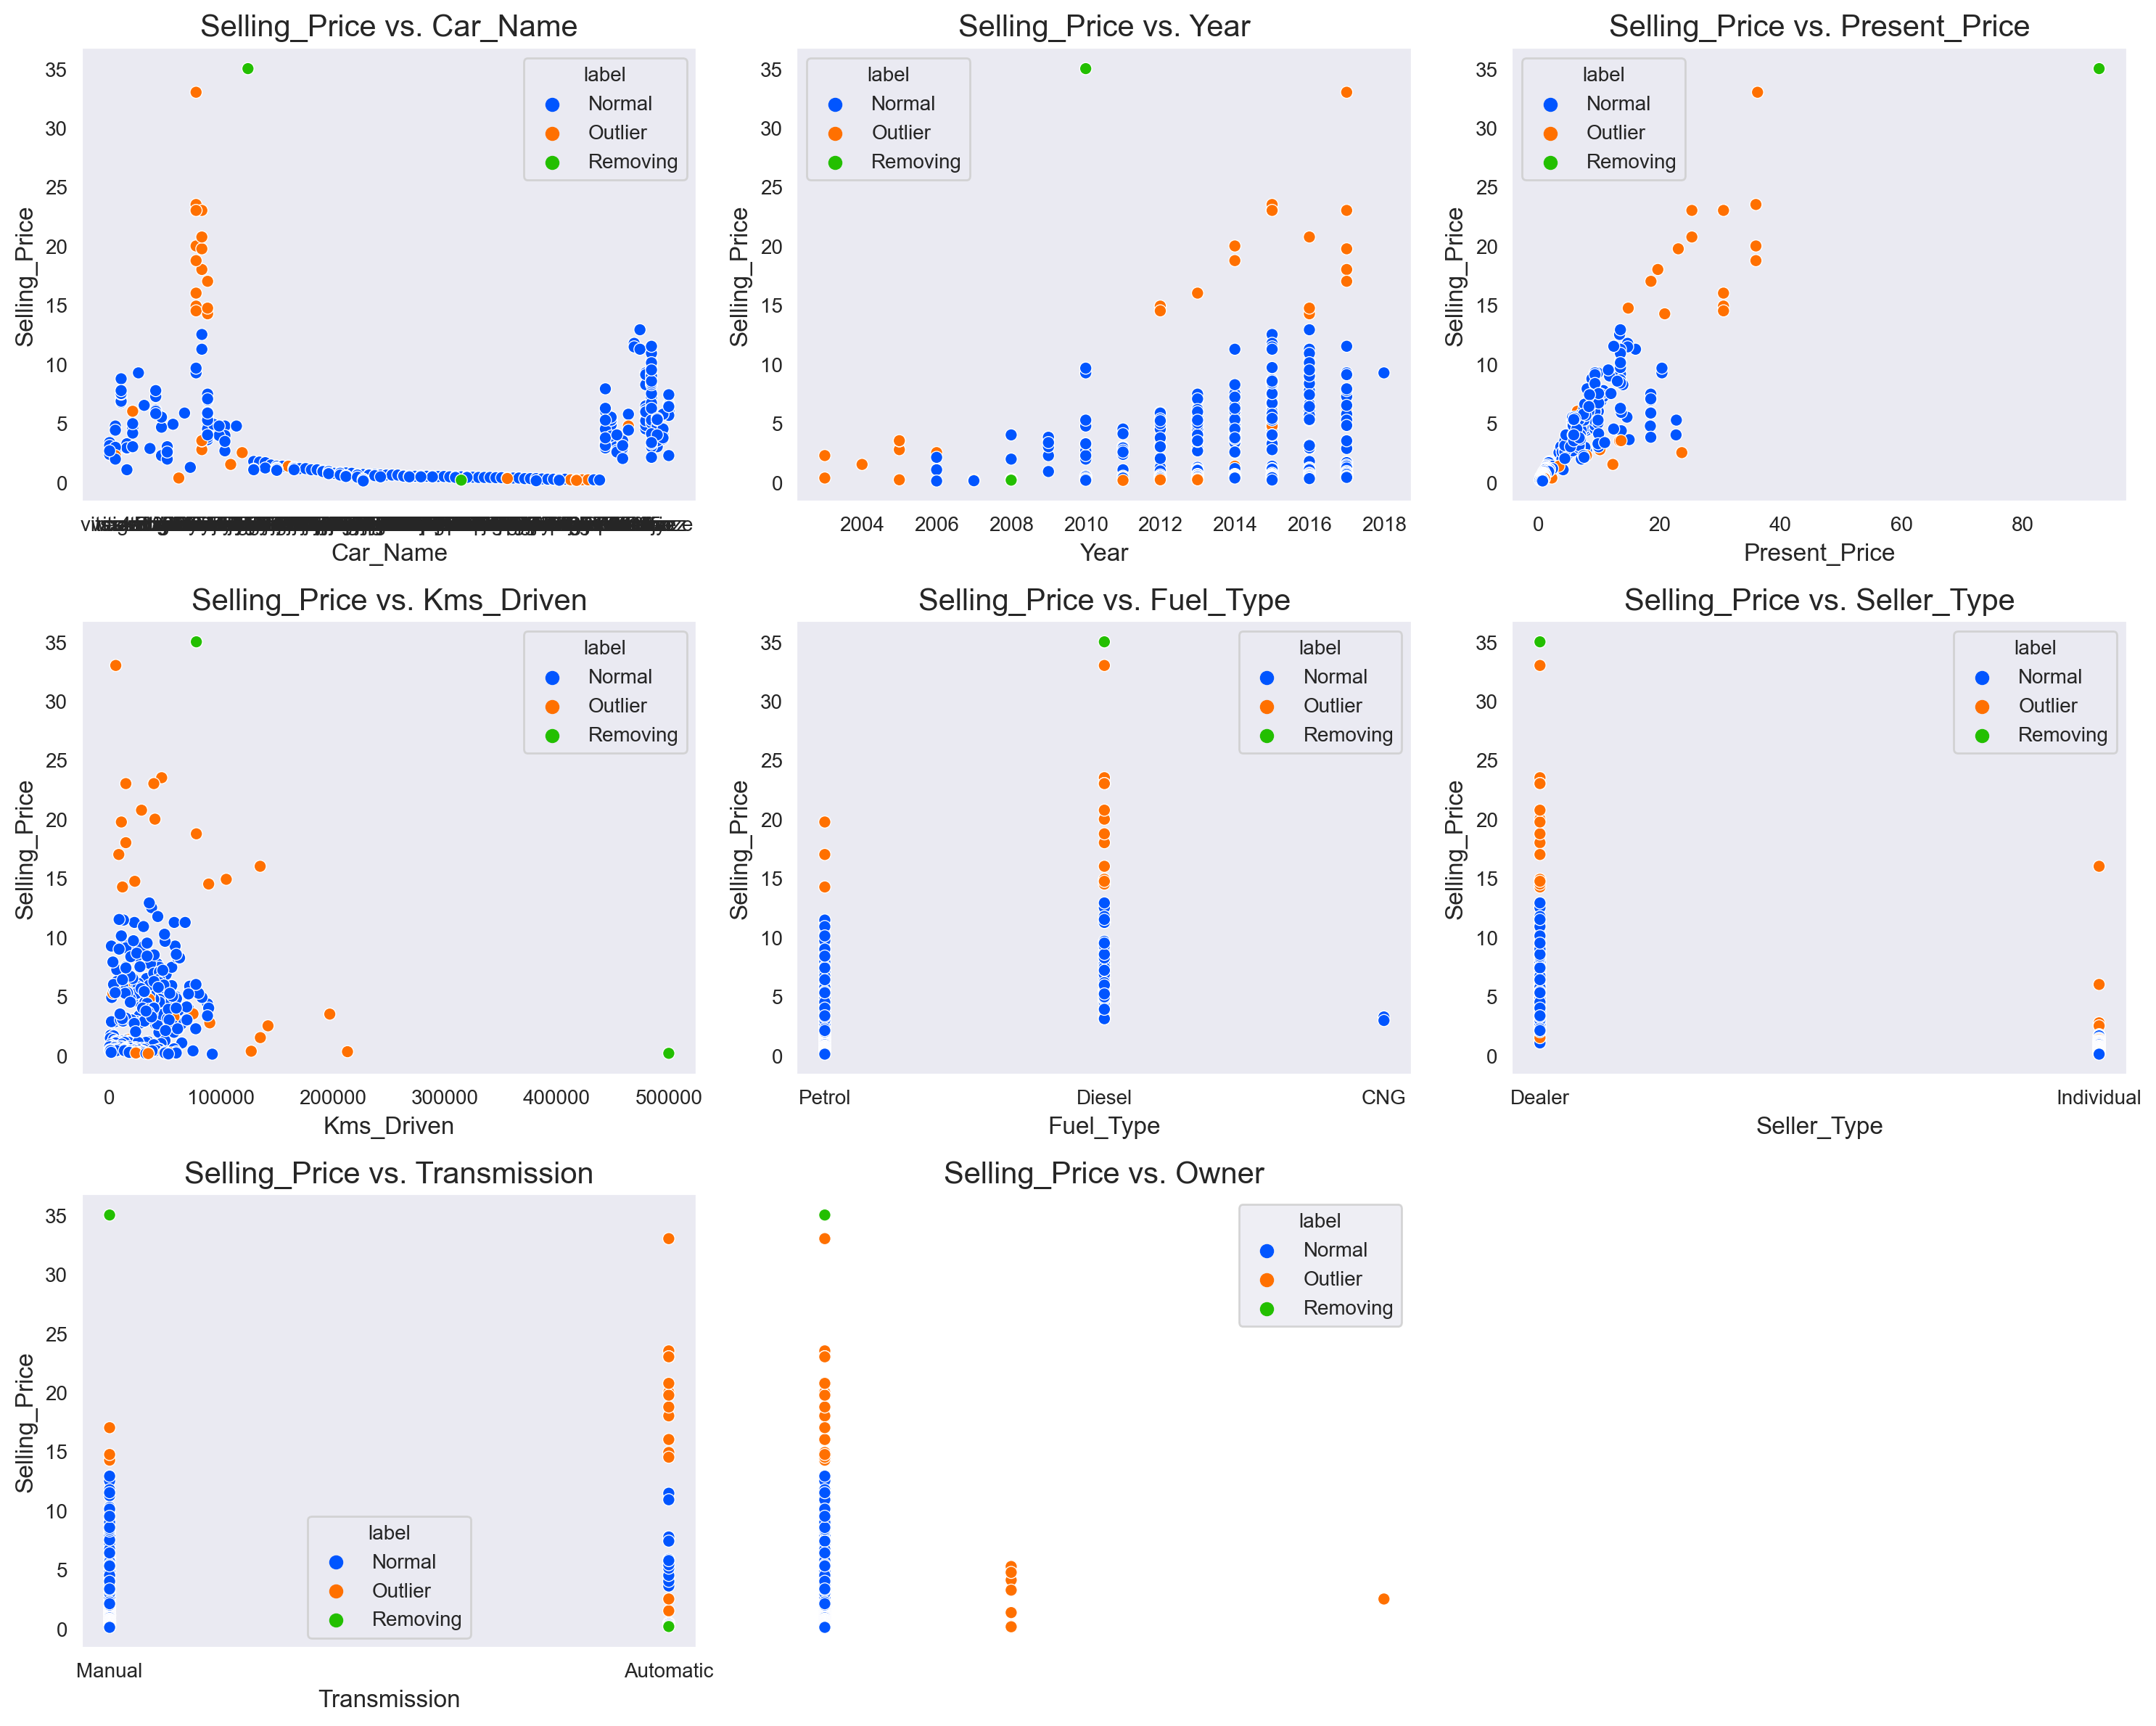

In [123]:
# Outliers Labeling
df1 = df.copy()
df1['label'] = 'Normal'
df1.loc[outliers_indexes,'label'] = 'Outlier'

# Removing Outliers
removing_indexes = []
removing_indexes.extend(df1[df1[target]>33].index)
removing_indexes.extend(df1[df1['Kms_Driven']>400000].index)
df1.loc[removing_indexes,'label'] = 'Removing'

# Plot
target = 'Selling_Price'
features = df.columns.drop(target)
colors = ['#0055ff','#ff7000','#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(nrows=3 ,ncols=3, figsize=(15,12), dpi=200)

for i in range(len(features)):
    x=i//3
    y=i%3
    sns.scatterplot(data=df1, x=features[i], y=target, hue='label', ax=ax[x,y])
    ax[x,y].set_title('{} vs. {}'.format(target, features[i]), size = 15)
    ax[x,y].set_xlabel(features[i], size = 12)
    ax[x,y].set_ylabel(target, size = 12)
    ax[x,y].grid()

ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

In [124]:
removing_indexes = list(set(removing_indexes))
removing_indexes

[196, 86]

In [125]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

Step 4.5: Discover Duplicates¶

In [126]:
df[df.duplicated(keep=False)]

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
15,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
17,ertiga,2016,7.75,10.79,43000,Diesel,Dealer,Manual,0
51,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0
93,fortuner,2015,23.00,30.61,40000,Diesel,Dealer,Automatic,0


Step 4.6: Drop Outliers


In [127]:
df1 = df.copy()
df1.drop(removing_indexes, inplace=True)
df1.reset_index(drop=True, inplace=True)

We removed just two samples as outliers.



Step 5: EDA


Step 5.1: Categorical Variables Univariate Analysis


In [128]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']


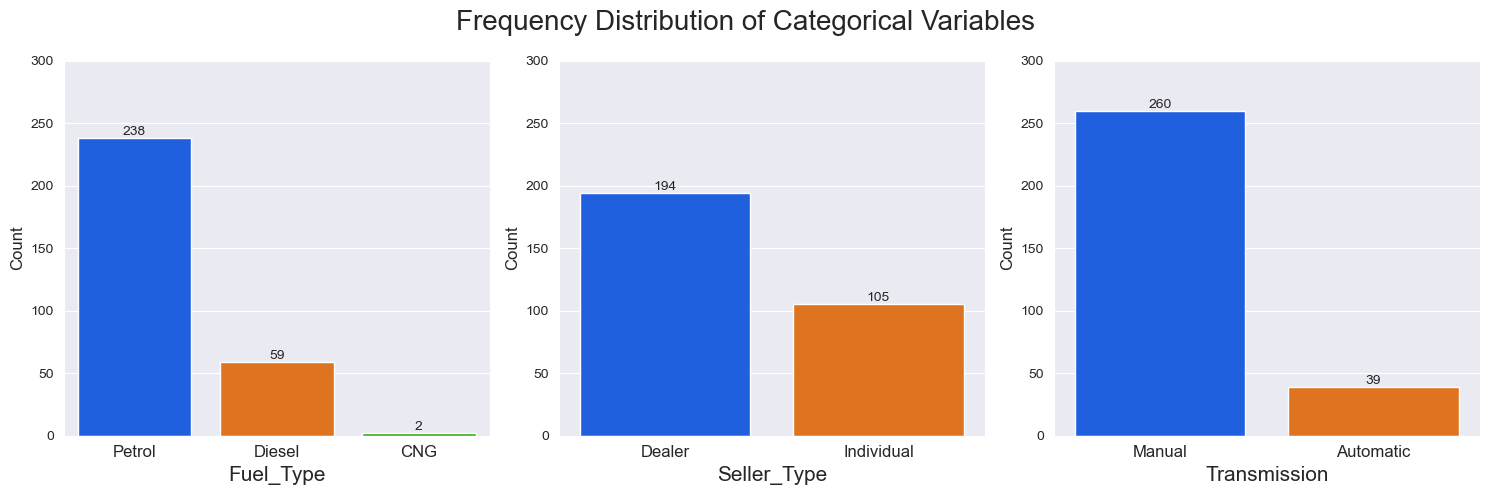

In [129]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100)
colors = ['#0055ff', '#ff7000', '#23bf00']
CustomPalette = sns.set_palette(sns.color_palette(colors))
       
for i in range(len(CatCols)):
    graph = sns.countplot(x=CatCols[i], data=df1, ax=ax[i])
    ax[i].set_xlabel(CatCols[i], fontsize=15)
    ax[i].set_ylabel('Count', fontsize=12)
    ax[i].set_ylim([0,300])
    ax[i].set_xticklabels(ax[i].get_xticklabels(), fontsize=12)
    for cont in graph.containers:
        graph.bar_label(cont)

plt.suptitle('Frequency Distribution of Categorical Variables', fontsize=20) 
plt.tight_layout()
plt.show()

Conclusion:
There are 3 Fuel_Type categories. Petrol has the highest frequency and CNG has the least frequency.
There are 2 Seller_Type categories. Dealer has the highest frequency and Individual has the least frequency.
There are 2 Transmission categories. Manual has the highest frequency and Automatic has the least frequency.

Step 5.2: Numerical Variables Univariate Analysis¶


In [130]:
NumCols = ['Age', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']


KeyError: 'Age'

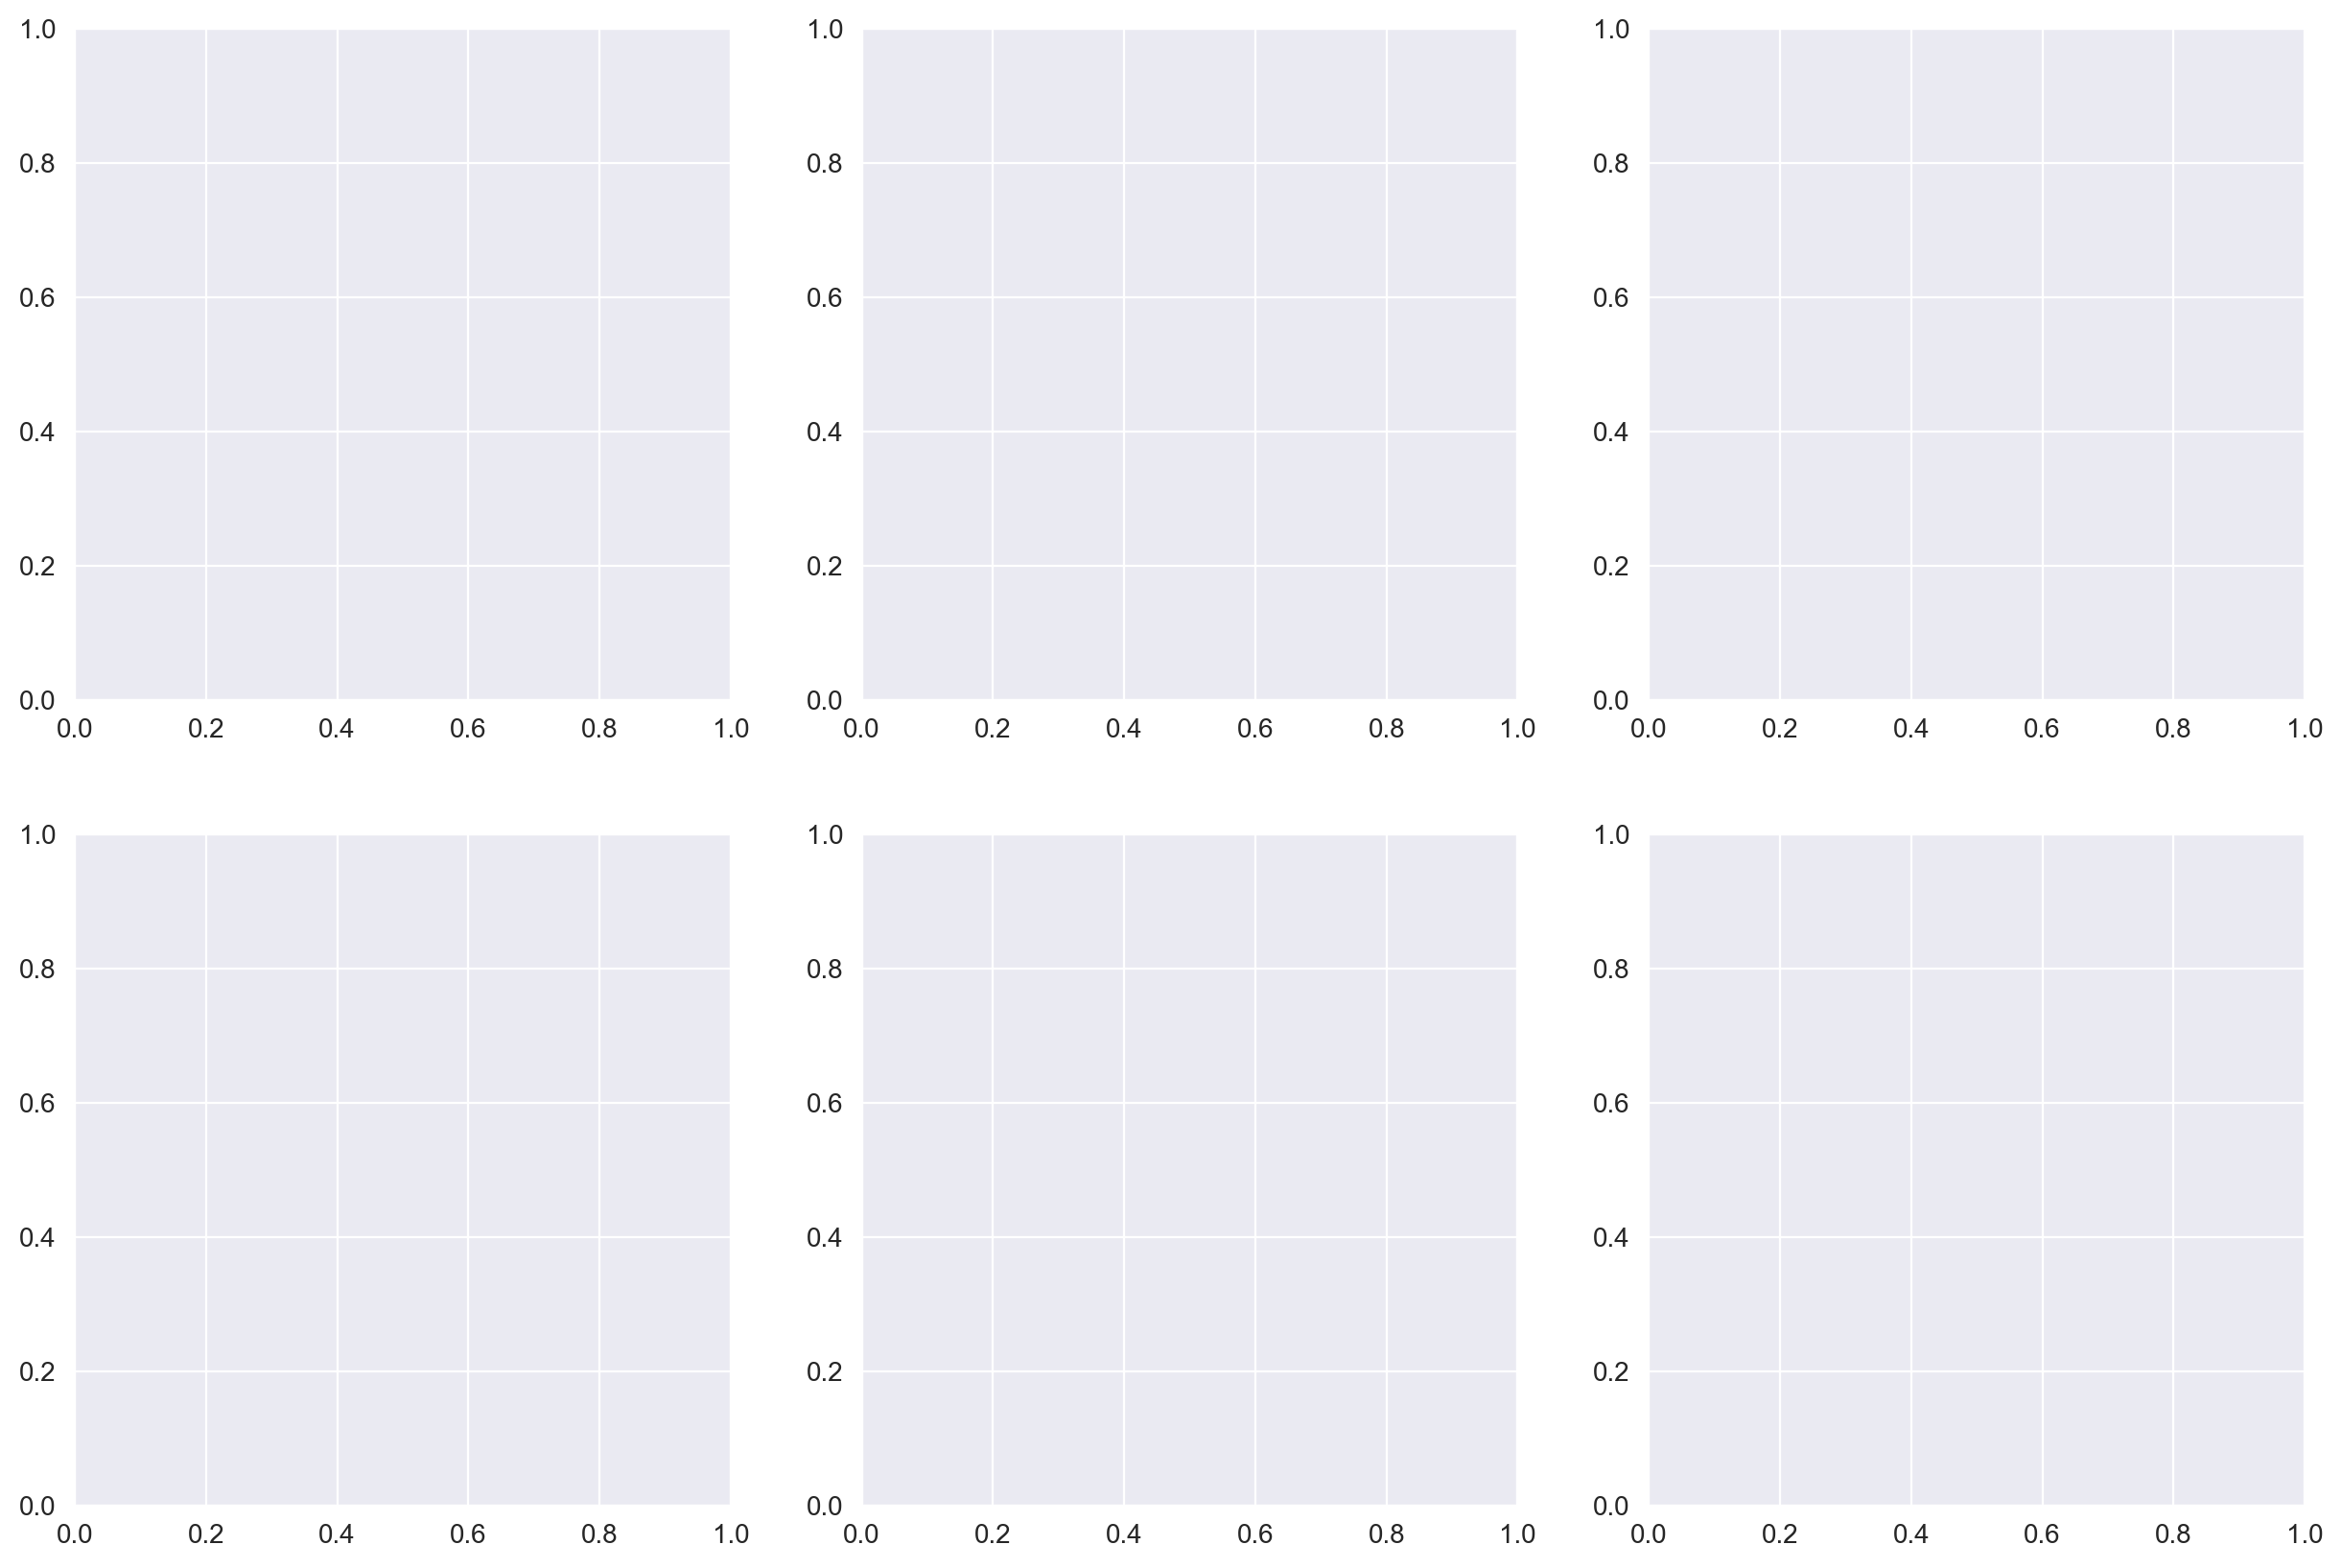

In [131]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10), dpi=200)
c = '#0055ff'

for i in range(len(NumCols)):
    row = i//3
    col = i%3
    values, bin_edges = np.histogram(df1[NumCols[i]], 
                                     range=(np.floor(df1[NumCols[i]].min()), np.ceil(df1[NumCols[i]].max())))                
    graph = sns.histplot(data=df1, x=NumCols[i], bins=bin_edges, kde=True, ax=ax[row,col],
                         edgecolor='none', color=c, alpha=0.4, line_kws={'lw': 2.5})
    ax[row,col].set_xlabel(NumCols[i], fontsize=15)
    ax[row,col].set_ylabel('Count', fontsize=12)
    ax[row,col].set_xticks(np.round(bin_edges,1))
    ax[row,col].set_xticklabels(ax[row,col].get_xticks(), rotation = 45)
    ax[row,col].grid(color='lightgrey')
    for j,p in enumerate(graph.patches):
        ax[row,col].annotate('{}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()+1),
                             ha='center', fontsize=10 ,fontweight="bold")
    
    textstr = '\n'.join((
    r'$\mu=%.2f$' %df1[NumCols[i]].mean(),
    r'$\sigma=%.2f$' %df1[NumCols[i]].std(),
    r'$\mathrm{median}=%.2f$' %np.median(df1[NumCols[i]]),
    r'$\mathrm{min}=%.2f$' %df1[NumCols[i]].min(),
    r'$\mathrm{max}=%.2f$' %df1[NumCols[i]].max()
    ))
    ax[row,col].text(0.6, 0.9, textstr, transform=ax[row,col].transAxes, fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))

ax[1, 2].axis('off')
plt.suptitle('Distribution of Numerical Variables', fontsize=20) 
plt.tight_layout()   
plt.show()


Step 5.3: Target vs. Numerical Features Bivariate Analysis

Plot Selling_Price vs. numerical features:



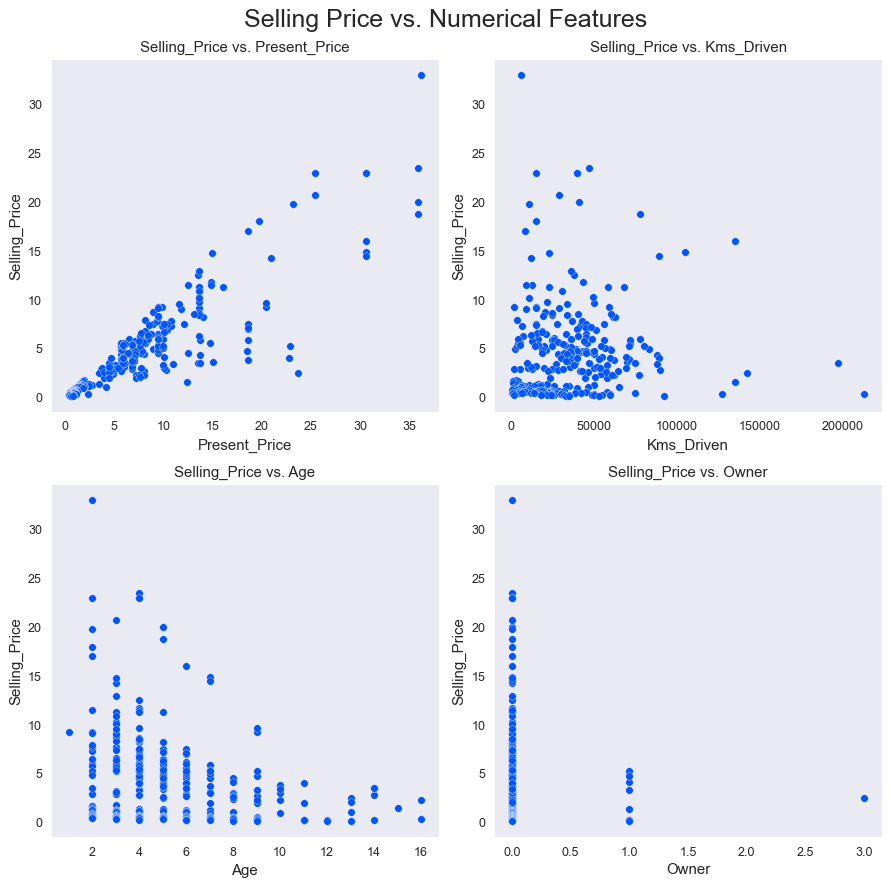

In [20]:
fig, ax = plt.subplots(nrows=2 ,ncols=2, figsize=(10,10), dpi=90)
num_features = ['Present_Price', 'Kms_Driven', 'Age', 'Owner']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(num_features)):
    row = i//2
    col = i%2
    ax[row,col].scatter(df1[num_features[i]], df1[target], color=c, edgecolors='w', linewidths=0.25)
    ax[row,col].set_title('{} vs. {}'.format(target, num_features[i]), size = 12)
    ax[row,col].set_xlabel(num_features[i], size = 12)
    ax[row,col].set_ylabel(target, size = 12)
    ax[row,col].grid()

plt.suptitle('Selling Price vs. Numerical Features', size = 20)
plt.tight_layout()
plt.show()

Conclusion:
As Present_Price increases, Selling_Price increases as well. So Selling_Price is directly proportional to Present_Price.

As the car's Kms_Driven increases, its Selling_Price decreases. So Selling_Price is inversely proportional to Kms_Driven.

As the car ages, its Selling_Price decreases. So Selling_Price is inversely proportional to the Age of the car.

As the number of previous car owners increases, its Selling_Price decreases. So Selling_Price is inversely proportional to Owner.

Step 5.4: Target vs. Categorical Features Bivariate Analysis¶

Selling_Price vs. categorical features strip plots:



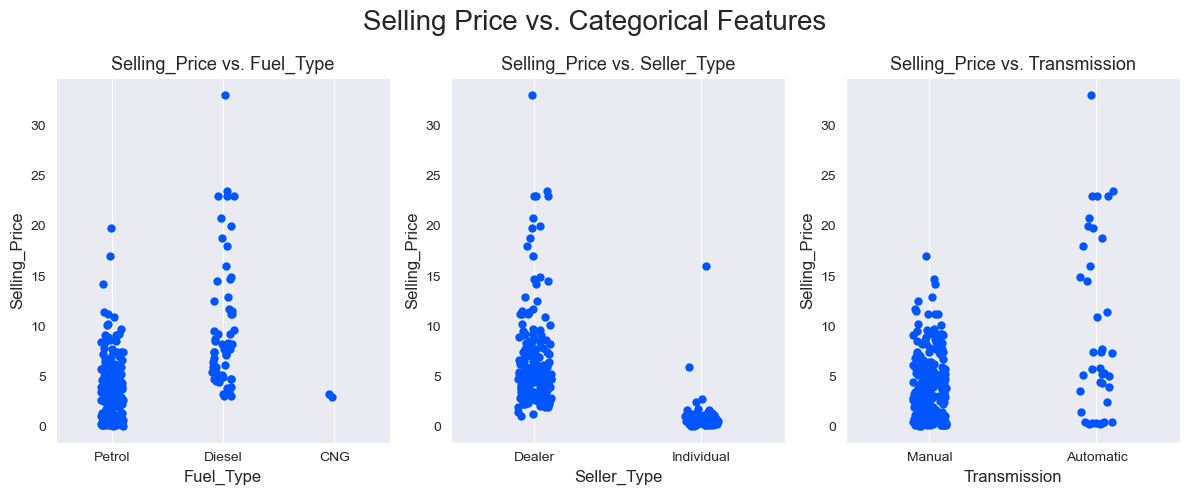

In [21]:
fig, axes = plt.subplots(nrows=1 ,ncols=3, figsize=(12,5), dpi=100)
cat_features = ['Fuel_Type', 'Seller_Type', 'Transmission']
target = 'Selling_Price'
c = '#0055ff'

for i in range(len(cat_features)):
    sns.stripplot(ax=axes[i], x=cat_features[i], y=target, data=df1, size=6, color=c)
    axes[i].set_title('{} vs. {}'.format(target, cat_features[i]), size = 13)
    axes[i].set_xlabel(cat_features[i], size = 12)
    axes[i].set_ylabel(target, size = 12)
    axes[i].grid()

plt.suptitle('Selling Price vs. Categorical Features', size = 20)
plt.tight_layout()
plt.show()

Conclusion:
Diesel Cars > CNG Cars > Petrol Cars in terms of Selling_Price.
The Selling_Price of cars sold by individuals is lower than the price of cars sold by dealers.
Automatic cars are more expensive than manual c

Step 5.5: Multivariate Analysis¶


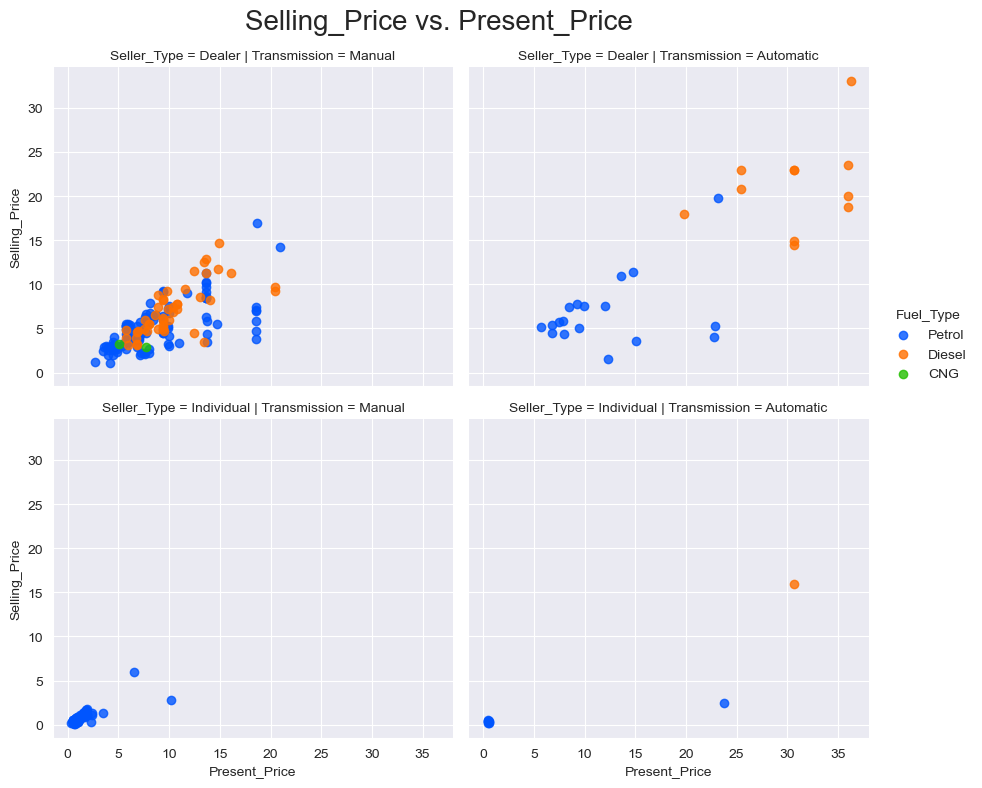

In [22]:
graph = sns.lmplot(x='Present_Price', y='Selling_Price', data= df1, fit_reg=False, row='Seller_Type',
                   col='Transmission', hue='Fuel_Type', palette=CustomPalette, height=4, aspect=1)   

plt.suptitle('Selling_Price vs. Present_Price', fontsize=20) 
sns.move_legend(graph, "lower center", bbox_to_anchor=(1.05, 0.5), ncol=1)
plt.tight_layout()
plt.show()

Conclusion:
All of the Individual Seller_Type have had Petrol cars.
Diesel cars all have belonged to the Dealer Seller_Type.
All of the CNG cars have had Manual Transmission and have belonged to Dealer Seller_Type.

Step 6: Categorical Variables Encoding
We implement dummy encoding on categorical columns, since they are all nominal variables:

In [23]:
CatCols = ['Fuel_Type', 'Seller_Type', 'Transmission']

df1 = pd.get_dummies(df1, columns=CatCols, drop_first=True)
df1.head(5)

,Age,Selling_Price,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5,3.35,5.59,27000,0,0,1,0,1
1,6,4.75,9.54,43000,0,1,0,0,1
2,2,7.25,9.85,6900,0,0,1,0,1
3,8,2.85,4.15,5200,0,0,1,0,1
4,5,4.60,6.87,42450,0,1,0,0,1


Step 7: Correlation Analysis¶


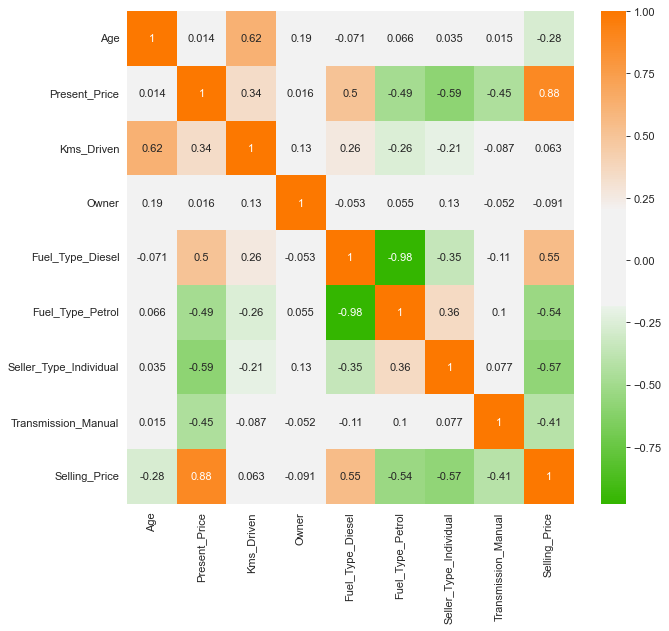

In [24]:
target = 'Selling_Price'
cmap = sns.diverging_palette(125, 28, s=100, l=65, sep=50, as_cmap=True)
fig, ax = plt.subplots(figsize=(9, 8), dpi=80)
ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)
plt.show()

The target variable "Selling Price" is highly correlated with Present_Price & Seller_Type & Fuel_Type.
Some independent variables like Fuel_Type_Petrol and Fuel_Type_Disel are highly correlated, which is called Multicollinearity.

Step 8: Build Linear Regression Model¶

Step 8.1: Determine Features & Target Variables¶


In [25]:
X = df1.drop('Selling_Price', axis=1)
y = df1['Selling_Price']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [27]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (209, 8)
X_test shape:  (90, 8)
y_train shape:  (209,)
y_test shape:  (90,)


In [28]:
y_test_actual = y_test


Step 8.3: Scale Data using Standard Scaler


In [29]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

It is very important that StandardScaler transformation should only be learnt from the training set, otherwise it will lead to data leakage.



Step 8.4: Train the Model¶


In [30]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [32]:
pd.DataFrame(data = np.append(linear_reg.intercept_ , linear_reg.coef_), 
             index = ['Intercept']+[col+" Coef." for col in X.columns], columns=['Value']).sort_values('Value', ascending=False)

,Value
Intercept,4.302488
Present_Price Coef.,3.492729
Fuel_Type_Diesel Coef.,0.850217
Fuel_Type_Petrol Coef.,0.207319
Transmission_Manual Coef.,0.027375
Owner Coef.,-0.232722
Seller_Type_Individual Coef.,-0.377334
Kms_Driven Coef.,-0.589672
Age Coef.,-0.936339


Step 8.5: Model Evaluation


In [33]:
def model_evaluation(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    R2_Score = metrics.r2_score(y_test, y_pred)
    
    return pd.DataFrame([MAE, MSE, RMSE, R2_Score], index=['MAE', 'MSE', 'RMSE' ,'R2-Score'], columns=[model_name])

In [34]:
model_evaluation(linear_reg, X_test_scaled, y_test, 'Linear Reg.')


,Linear Reg.
MAE,1.198867
MSE,3.714913
RMSE,1.927411
R2-Score,0.887245


Step 8.6: Model Evaluation using Cross-Validation¶
By using cross-validation, we can have more confidence in our estimation for the model evaluation metrics than the former simple train-test split:

In [35]:
linear_reg_cv = LinearRegression()
scaler = StandardScaler()
pipeline = make_pipeline(StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result['test_neg_mean_absolute_error']).mean()
MAE_std = (-result['test_neg_mean_absolute_error']).std()
MSE_mean = (-result['test_neg_mean_squared_error']).mean()
MSE_std = (-result['test_neg_mean_squared_error']).std()
RMSE_mean = (-result['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result['test_r2'].mean()
R2_Score_std = result['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,1.154774,0.147377
MSE,3.131755,1.314319
RMSE,1.728702,0.378609
R2-Score,0.855703,0.033720


The linear regression model obtained R2-score of %85.57 using 6-fold cross-validation.

Pipeline is a great way to prevent data leakage as it ensures that the appropriate method is performed on the correct data subset. This is ideal for using in cross-validation since it ensures that only the training folds are used when performing fit and the test set (validation set) is used only for calculating the accuracy score in each iteration of cross-validation.

Step 8.7: Assumptions
We need to check the assumptions of linear regression, because if the assumptions are not met, the interpretation of the results will not always be valid:

Step 8.7.1: Assumption 1 - Linearity
This assumes that there is a linear relationship between the independent variables or features and the dependent variable or label. Fitting a linear model to data with non-linear patterns results in serious prediction errors, because our model is underfitting.

To detect nonlinearity, we can check:

Plots of actual vs. predicted values -> The desired outcome is that points are symmetrically distributed around a diagonal line
Plots of residuals vs. predicted values -> The desired outcome is that points are symmetrically distributed around a horizontal line
In both cases we should have an almost constant variance.

In [36]:
def residuals(model, X_test, y_test):
    '''
    Creates predictions on the features with the model and calculates residuals
    '''
    y_pred = model.predict(X_test)
    df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [37]:
def linear_assumption(model, X_test, y_test):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model
    '''
    df_results = residuals(model, X_test, y_test)
    
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', data=df_results, lowess=True, ax=ax[0],
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    ax[0].set_title('Actual vs. Predicted Values', fontsize=15)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)        
    
    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True, ax=ax[1],
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=15)
    ax[1].set_xlabel('Predicted', fontsize=12)
    ax[1].set_ylabel('Residuals', fontsize=12)  

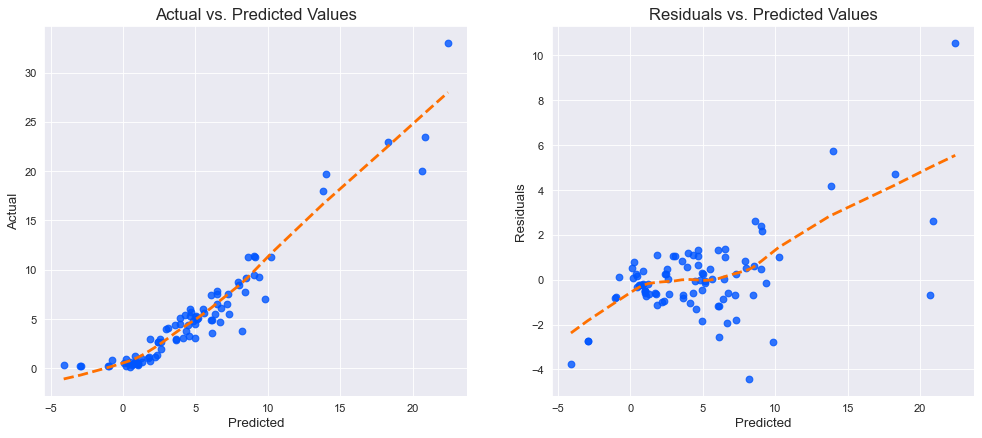

In [38]:
linear_assumption(linear_reg, X_test_scaled, y_test)

The inspection of the plots shows that the linearity assumption is not satisfied.



Potential solutions:

Applying nonlinear transformations
Adding polynomial terms to some of the predictors

Step 8.7.2: Assumption 2 - Normality of Residuals
This assumes that the error terms of the model are normally distributed with a mean value of zero.

This can actually happen if either the predictors or the label are significantly non-normal. Other potential reasons could include the linearity assumption being violated or presence of a few large outliers in data affecting our model.

A violation of this assumption could cause issues with either shrinking or inflating our confidence intervals. When the residuals distribution significantly departs from Gaussian, confidence intervals may be too wide or too narrow. Technically, we can omit this assumption if we assume instead that the model equation is correct and our goal is to estimate the coefficients and generate predictions (in the sense of minimizing mean squared error). However, normally we are interested in making valid inferences from the model or estimating the probability that a given prediction error will exceed some threshold in a particular direction. To do so, the assumption about the normality of residuals must be satisfied.

To investigate this assumption we can check:

Check residuals histogram
Quantile-Quantile probability plot -> plotting the residuals vs the order of statistic
Anderson-Darling test

In [39]:
def normal_errors_assumption(model, X_test, y_test, p_value_thresh=0.05):
    '''
    Function for inspecting the assumption of normality of residuals.
    '''
    df_results = residuals(model, X_test, y_test)
    
    # Anderson-Darling Test
    p_value = normal_ad(df_results['Residuals'])[1]
    
    print('\nP-value from the test (below 0.05 generally means non-normal):  ', np.round(p_value,6))
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed. Assumption not satisfied.') 
    else:
        print('Residuals are normally distributed. Assumption satisfied.')

      
    # Residuals Histogram
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)
    
    sns.histplot(data=df_results, x='Residuals', kde=True, ax=ax[0], bins=15, 
                 color='#0055ff', edgecolor='none', alpha=0.4, line_kws={'lw': 2.5})
    ax[0].set_xlabel('Residuals', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Distribution of Residuals', fontsize=15)
    textstr = '\n'.join((
        r'$\mu=%.2f$' %np.mean(df_results['Residuals']),
        r'$\sigma=%.2f$' %np.std(df_results['Residuals']),
        ))
    ax[0].text(0.7, 0.9, textstr, transform=ax[0].transAxes, fontsize=15, verticalalignment='top',
                 bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))
    
    
    # Q-Q Probability Plot
    stats.probplot(df_results['Residuals'], dist="norm", plot= ax[1])
    ax[1].set_title("Residuals Q-Q Plot", fontsize=15)
    ax[1].set_xlabel('Theoretical Quantiles', fontsize=12)
    ax[1].set_ylabel('Ordered Values', fontsize=12)
    ax[1].get_lines()[0].set_markerfacecolor('#509aff')
    ax[1].get_lines()[1].set_color('#ff7000')
    ax[1].get_lines()[1].set_linewidth(2.5)
    ax[1].get_lines()[1].set_linestyle('--')
    ax[1].legend(['Actual','Theoretical'])
    
    plt.show()


P-value from the test (below 0.05 generally means non-normal):   0.0
Residuals are not normally distributed. Assumption not satisfied.


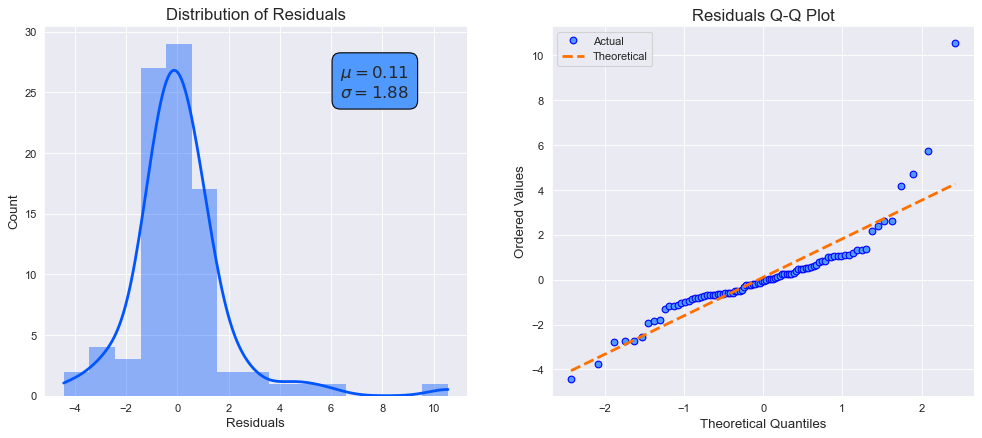

In [40]:
normal_errors_assumption(linear_reg, X_test_scaled, y_test)


 QQ Plot of residuals:

The bow-shaped pattern of deviations from the diagonal implies that the residuals have excessive skewness.
The s-shaped pattern of deviations from the diagonal implies excessive kurtosis of the residuals (there are either too many or too few large errors in both directions.)
The non-zero mean value and the positive skewness of the residual distribution and the s-shaped pattern of the deviations in the QQ plot show that the residuals do not follow the Gaussian distribution.

Potential solutions:

Nonlinear transformation of target variable and features
Removing potential outliers

Step 8.7.3: Assumption 3 - No Perfect Multicollinearity
Multicollinearity occurs when the independent variables are correlated to each other. It becomes difficult for the model to estimate the relationship between each independent variable and the dependent variable independently because the independent variables tend to change in unison. The coefficient estimates can swing wildly based on which other independent variables are in the model and they become very sensitive to small changes in the model. Therefore, the estimates will be less precise and highly sensitive to particular sets of data. This increases the standard error of the coefficients, which results in them potentially showing as statistically insignificant when they might actually be significant. On the other hand, the simultaneous changes of the independent variables can lead to large fluctuations of the target variable, which leads to the overfitting of the model and the reduction of its performance.

To detect multicolinearity, we can:

Use a heatmap of the correlation (step 7)
Examine the variance inflation factor (VIF)
Interpretation of VIF: The square root of a given variable’s VIF shows how much larger the standard error is, compared with what it would be if that predictor were uncorrelated with the other features in the model. The higher the value of VIF the higher correlation between this variable and the rest. A rule of thumb is that if VIF > 10 then multicollinearity is high.

In [41]:
X['Fuel_Type_Diesel'] = X['Fuel_Type_Diesel']*1
X['Fuel_Type_Petrol'] = X['Fuel_Type_Petrol']*1
X['Seller_Type_Individual'] = X['Seller_Type_Individual']*1
X['Transmission_Manual'] = X['Transmission_Manual']*1

In [42]:
def multicollinearity_assumption(X):
    ''''
    This assumes that predictors are not correlated with each other and calculates VIF values of predictors
    '''
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    possible_multicollinearity = sum([1 for v in vif if v > 10])
    definite_multicollinearity = sum([1 for v in vif if v > 100])
    
    print('{} cases of possible multicollinearity.'.format(possible_multicollinearity))
    print('{} cases of definite multicollinearity.'.format(definite_multicollinearity))
    
    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied.')
        else:
            print('Assumption possibly satisfied.')
    else:
        print('Assumption not satisfied.')
    
    return pd.DataFrame({'vif': vif}, index=X.columns).round(2)

In [43]:
multicollinearity_assumption(X)


1 cases of possible multicollinearity.
0 cases of definite multicollinearity.
Assumption possibly satisfied.


,vif
Age,8.15
Present_Price,5.14
Kms_Driven,5.34
Owner,1.10
Fuel_Type_Diesel,6.11
Fuel_Type_Petrol,16.86
Seller_Type_Individual,2.61
Transmission_Manual,9.59


There is possible multicollinearity for Fuel_Type_Petrol.



Potential solutions:

Using Regularization
Removing features with high values of VIF
Using PCA -> Reducing features to a smaller set of uncorrelated components

Step 8.7.4: Assumption 4 - No Autocorrelation of Residuals¶


This assumes no autocorrelation of the residuals. The presence of autocorrelation usually indicates that we are missing some information that should be captured by the model. Our model can be systematically biased by under-prediction or over-prediction under certain conditions. This could be the result of violating the linearity assumption.

To investigate this assumption we can perform a Durbin-Watson test to determine whether the correlation is positive or negative:

The test statistic always has a value between 0 and 4
Values of 1.5 < d < 2.5 means that there is no autocorrelation in the data
Values < 1.5 indicate positive autocorrelation, values > 2.5 indicate negative autocorrelation

In [44]:
def autocorrelation_assumption(model, X_test, y_test):
    '''
    It assumes that there is no autocorrelation in the residuals. If there is autocorrelation, then 
    there is a pattern that is not explained because the current value is dependent on the previous value.
    '''
    df_results = residuals(model, X_test, y_test)

    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', round(durbinWatson,3))
    
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation. Assumption not satisfied.', '\n')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation. Assumption not satisfied.', '\n')
    else:
        print('Little to no autocorrelation. Assumption satisfied.', '\n')

In [45]:
autocorrelation_assumption(linear_reg, X_test_scaled, y_test)


Durbin-Watson: 1.823
Little to no autocorrelation. Assumption satisfied. 



Durbin-Watson test indicates there is no autocorrelation.

Potential solution for fixing autocorrelation of residuals:

Adding interaction terms

Step 8.7.5: Assumption 5 - Homoscedasticity
Homoscedasticity means that the residuals doesn’t change across all the values of the target variable.

When residuals do not have constant variance, it is difficult to determine the true standard deviation of the forecast errors, usually resulting in confidence intervals that are too wide/narrow. The effect of heteroscedasticity might also be putting too much weight to a subset of data when estimating coefficients.

To investigate if the residuals are homoscedastic, we can look at a plot of residuals vs. predicted values. The placement of the points should be random and no pattern (increase/decrease in values of residuals) should be visible.

In [46]:
def homoscedasticity_assumption(model, X_test, y_test):
    """
    Homoscedasticity assumes that the residuals exhibit constant variance
    """
    print('The orange line should be flat:')
    df_results = residuals(model, X_test, y_test)
    
    fig = plt.figure(figsize=(6,6), dpi=80)
    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True,
                color='#0055ff', line_kws={'color':'#ff7000','ls':'--','lw':2.5})
    plt.axhline(y=0, color='#23bf00', lw=1)
    plt.title('Residuals vs. Predicted Values', fontsize=15)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)    
    plt.show()

The orange line should be flat:


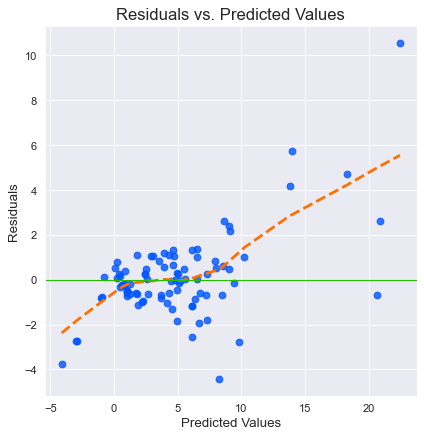

In [47]:
homoscedasticity_assumption(linear_reg, X_test_scaled, y_test)


We can not see a fully uniform variance across our residuals because the orange line is not flat. The assumption is not satisfied.


Potential solutions:

Outlier removal
Appllying log transformation of independent variables
Applying polynomial regression


In the following:
To satisfy the multicollinearity assumption, we remove the Fuel_Type_Petrol feature.
Then, according to the pattern in the plot of the residuals vs. predicted values, we will use box-cox transformation on the entire dataset.
By applying polynomial regression, we will try to improve the satisfaction of homoscedasticity and normality of residuals.
Finally, we will use regularization to reduce the probability of the model to be overfit.
Drop Fuel_Type_Petrol:

In [48]:
del df1['Fuel_Type_Petrol']


Step 8.8: Results Visualization
We compare the actual and predicted target values for the test data with the help of a bar plot:

In [49]:
y_test_pred = linear_reg.predict(X_test_scaled)
df_comp = pd.DataFrame({'Actual':y_test_actual, 'Predicted':y_test_pred})

In [50]:
def compare_plot(df_comp):
    df_comp.reset_index(inplace=True)
    df_comp.plot(y=['Actual','Predicted'], kind='bar', figsize=(20,7), width=0.8)
    plt.title('Predicted vs. Actual Target Values for Test Data', fontsize=20)
    plt.ylabel('Selling_Price', fontsize=15)
    plt.show()

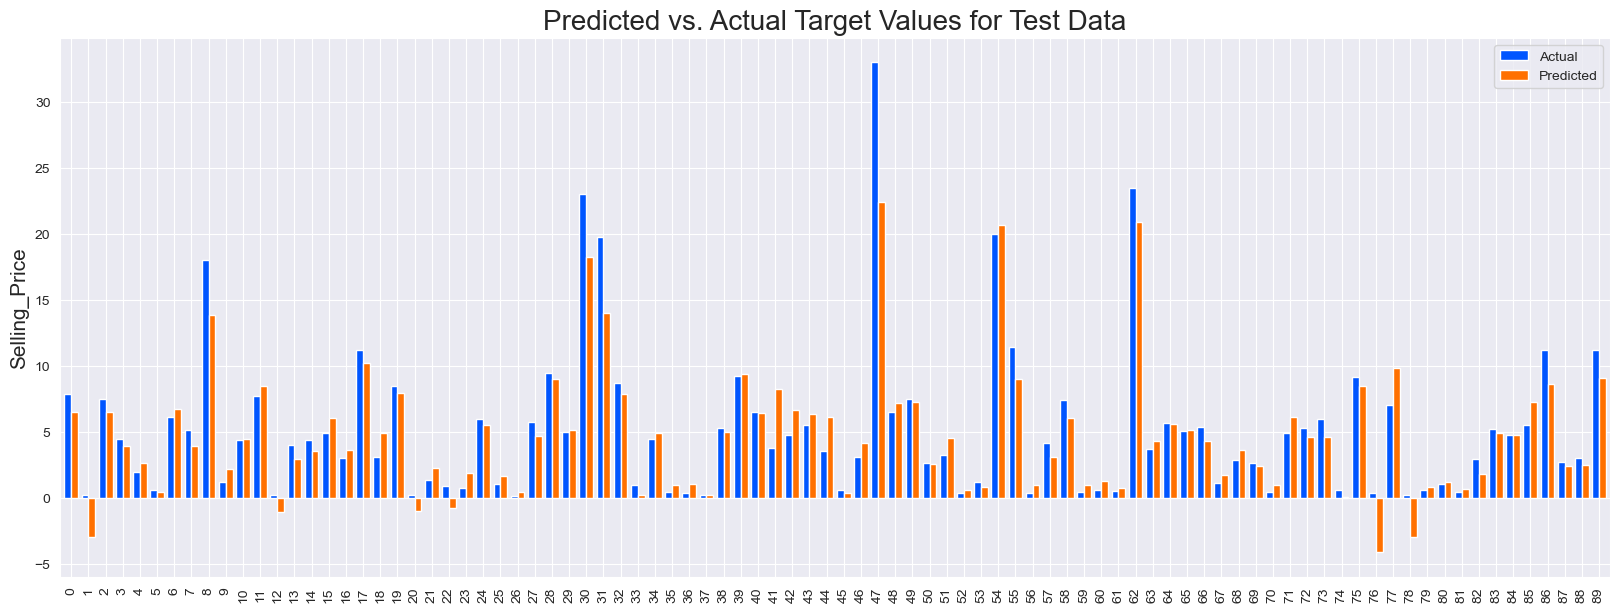

In [51]:
compare_plot(df_comp)


The difference between the corresponding bars in the above bar plot shows the prediction error of the model on the test data. Also, out of 90 test samples, Selling_Price has been predicted negatively in 6 cases. A negative prediction for Selling_Price is disappointing.

Step 9: Apply Box-Cox Transformation:


In order to satisfy the regression assumptions, we apply the Box-Cox transformation on the whole dataset. The Box-Cox transformations change the shape of our data, making it more close to a normal distribution.

In order to prevent data leakage, the fitted lambda value for each feature is obtained from the training data set and then the transformation is applied to the both training and test data:



Step 9.1: Transform Training Data & Save Lambda Values¶


In [52]:
fitted_lambda = pd.Series(np.zeros(len(df1.columns), dtype=np.float64), index=df1.columns)

y_train, fitted_lambda['Selling_Price'] = stats.boxcox(y_train+1)
for col in X_train.columns:
    X_train[col], fitted_lambda[col] = stats.boxcox(X_train[col]+1)
    
fitted_lambda

Age                       -0.360231
Selling_Price             -0.035121
Present_Price              0.078725
Kms_Driven                 0.350131
Owner                    -30.152327
Fuel_Type_Diesel          -7.291035
Seller_Type_Individual    -2.568079
Transmission_Manual       14.414394
Fuel_Type_Petrol           6.903209
dtype: float64

Step 9.2: Transform Test Data Using Lambda Values¶


In [53]:
y_test = stats.boxcox(y_test+1, fitted_lambda['Selling_Price'])
for col in X_test.columns:
    X_test[col] = stats.boxcox(X_test[col]+1, fitted_lambda[col])

In [54]:
y_train = pd.DataFrame(y_train, index=X_train.index, columns=['Selling_Price'])
y_test = pd.DataFrame(y_test, index=X_test.index, columns=['Selling_Price'])

X_boxcox = pd.concat([X_train, X_test])
y_boxcox = pd.concat([y_train, y_test])

df_boxcox = pd.concat([X_boxcox, y_boxcox], axis=1)
df_boxcox.sort_index(inplace=True)

del df_boxcox['Fuel_Type_Petrol']

As seen in Step 5.2, the distribution of continuous variables all had a lot of positive skewness. In the following, we can see the change in the shape of the distribution of these variables after applying Box-Cox transformation:

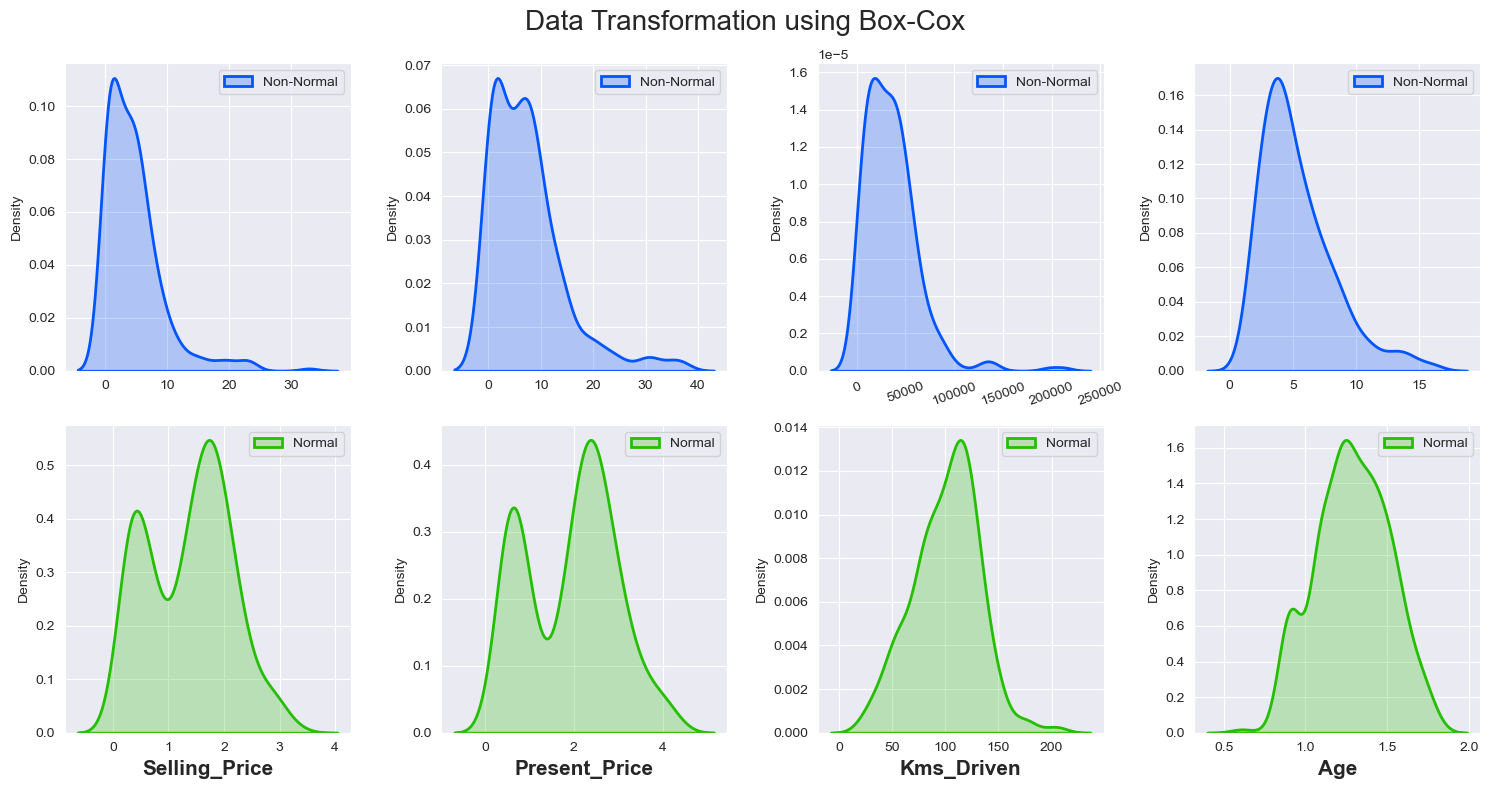

In [55]:
fig, ax = plt.subplots(2, 4, figsize=(15,8), dpi=100)
columns = ['Selling_Price', 'Present_Price', 'Kms_Driven', 'Age']

for i,col in enumerate(columns):
    sns.kdeplot(df1[col], label="Non-Normal", fill=True, color='#0055ff', linewidth=2, ax=ax[0,i])
    sns.kdeplot(df_boxcox[col], label="Normal", fill=True, color='#23bf00', linewidth=2, ax=ax[1,i])  
    ax[0,i].set_xlabel('', fontsize=15)
    ax[1,i].set_xlabel(col, fontsize=15, fontweight='bold')
    ax[0,i].legend(loc="upper right")
    ax[1,i].legend(loc="upper right")

ax[0,2].tick_params(axis='x', labelrotation = 20)
plt.suptitle('Data Transformation using Box-Cox', fontsize=20)
plt.tight_layout()
plt.show()

As can be seen, the distribution of the variables is closer to the normal distribution after applying Box-Cox.



In [56]:
X = df_boxcox.drop('Selling_Price', axis=1)
y = df_boxcox['Selling_Price']

Now box-cox transformation is applied on X and y. Next, we will add higher order features to the model.



Step 10: Build 2nd-order Polynomial Regression¶


In order to overcome under-fitting and meet linear regression assumptions, first we try to increase the complexity of the model by adding all of the second-order terms of the features

Step 10.1: Create 2nd-order Polynomial Features¶


In [57]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
X_poly.head(5)

,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Owner^2,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel^2,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
0,1.320187,2.032688,98.846654,0.0,0.000000,0.0,1514.777352,1.742893,2.683528,130.496050,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.294550e+06
1,1.398824,2.587658,116.843776,0.0,0.136279,0.0,1514.777352,1.956709,3.619679,163.443905,...,0.0,0.0,0.0,0.0,0.018572,0.0,206.432287,0.0,0.0,2.294550e+06
2,0.907273,2.622591,60.223871,0.0,0.000000,0.0,1514.777352,0.823145,2.379406,54.639502,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.294550e+06
3,1.518024,1.749435,54.276845,0.0,0.000000,0.0,1514.777352,2.304398,2.655684,82.393575,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,2.294550e+06
4,1.320187,2.240043,116.305479,0.0,0.136279,0.0,1514.777352,1.742893,2.957275,153.544961,...,0.0,0.0,0.0,0.0,0.018572,0.0,206.432287,0.0,0.0,2.294550e+06


In [58]:
poly_features_names = poly_features.get_feature_names_out(X.columns)
len(poly_features_names)

35

Step 10.2: Split Dataset to Training & Test Sets¶


In [59]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

In [60]:
print('X_poly_train shape: ', X_poly_train.shape)
print('X_poly_test shape: ', X_poly_test.shape)
print('y_poly_train shape: ', y_poly_train.shape)
print('y_poly_test shape: ',y_poly_test.shape)

X_poly_train shape:  (209, 35)
X_poly_test shape:  (90, 35)
y_poly_train shape:  (209,)
y_poly_test shape:  (90,)


Step 10.3: Scale Data using Standard Scaler¶


In [61]:
scaler = StandardScaler()
scaler.fit(X_poly_train)

X_poly_train = scaler.transform(X_poly_train)
X_poly_train = pd.DataFrame(X_poly_train, columns=poly_features_names)

X_poly_test = scaler.transform(X_poly_test)
X_poly_test = pd.DataFrame(X_poly_test, columns=poly_features_names)

Step 10.4: Create Polynomial Regression Model using Linear Regression¶


In [62]:
polynomial_reg = LinearRegression()
polynomial_reg.fit(X_poly_train, y_poly_train)

LinearRegression()

Step 10.5: Model Evaluation


2nd-order Polynomial Model Performance on Test Data:



In [63]:
model_evaluation(polynomial_reg, X_poly_test, y_poly_test, 'Polynomial Reg. Test')


,Polynomial Reg. Test
MAE,0.088163
MSE,0.011432
RMSE,0.106920
R2-Score,0.981584


2nd-order Polynomial Model Performance on Training Data:



In [64]:
model_evaluation(polynomial_reg, X_poly_train, y_poly_train, 'Polynomial Reg. Train')


,Polynomial Reg. Train
MAE,0.064327
MSE,0.006435
RMSE,0.080222
R2-Score,0.988170


As can be seen, using boxcox transformation and production of second-order features has improved the model performance greatly!

MAE: 1.199 -> 0.088

MSE: 3.715 -> 0.011

RMSE: 1.927 -> 0.107

R2 Score: %88.72 -> %98.16

The accuracy of the model on the training and test data are close to each other, so the model is not overfit.
The production of third-order and higher features was also tested, which caused the model to become overfit.

Step 10.6: Model Evaluation using Cross-Validation
By using cross-validation, we can be more confident in our estimation of the model evaluation metrics:

In [65]:
pipeline = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),  LinearRegression())

kf = KFold(n_splits=6, shuffle=True, random_state=0) 
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'r2']
result2 = cross_validate(pipeline, X, y, cv=kf, return_train_score=True, scoring=scoring)

MAE_mean = (-result2['test_neg_mean_absolute_error']).mean()
MAE_std = (-result2['test_neg_mean_absolute_error']).std()
MSE_mean = (-result2['test_neg_mean_squared_error']).mean()
MSE_std = (-result2['test_neg_mean_squared_error']).std()
RMSE_mean = (-result2['test_neg_root_mean_squared_error']).mean()
RMSE_std = (-result2['test_neg_root_mean_squared_error']).std()
R2_Score_mean = result2['test_r2'].mean()
R2_Score_std = result2['test_r2'].std()

pd.DataFrame({'Mean': [MAE_mean,MSE_mean,RMSE_mean,R2_Score_mean], 'Std': [MAE_std,MSE_std,RMSE_std,R2_Score_std]},
             index=['MAE', 'MSE', 'RMSE' ,'R2-Score'])

,Mean,Std
MAE,0.079857,0.009664
MSE,0.011984,0.005636
RMSE,0.106877,0.023692
R2-Score,0.978172,0.010858


The accuracy obtained from the simple train test split is valid because it is close to the accuracy obtained from cross validation.

So far, we have a polynomial model consisting of 35 features with 98.16% r2-score. Lets check regression assumptions for this model.

Step 10.7: Assumptions Investigation
Step 10.7.1: Assumption 1 - Linearity

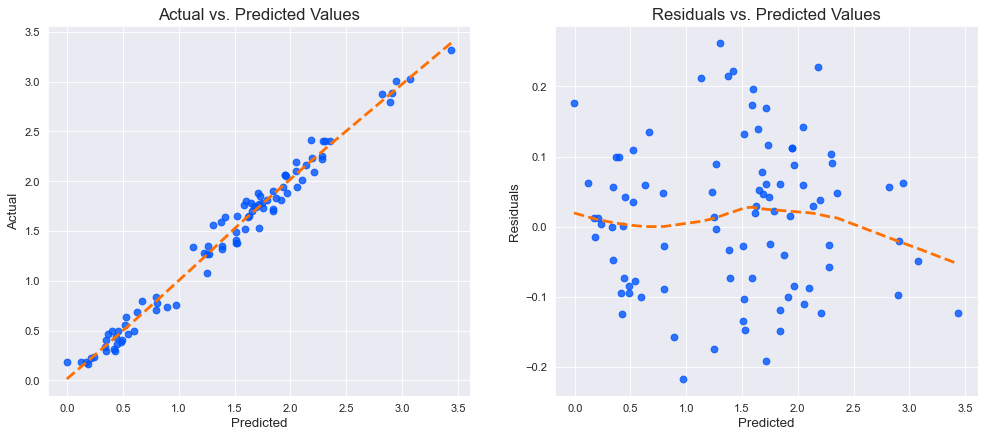

In [66]:
linear_assumption(polynomial_reg, X_poly_test, y_poly_test)


Step 10.7.2: Assumption 2 - Normality of Residuals¶



P-value from the test (below 0.05 generally means non-normal):   0.450843
Residuals are normally distributed. Assumption satisfied.


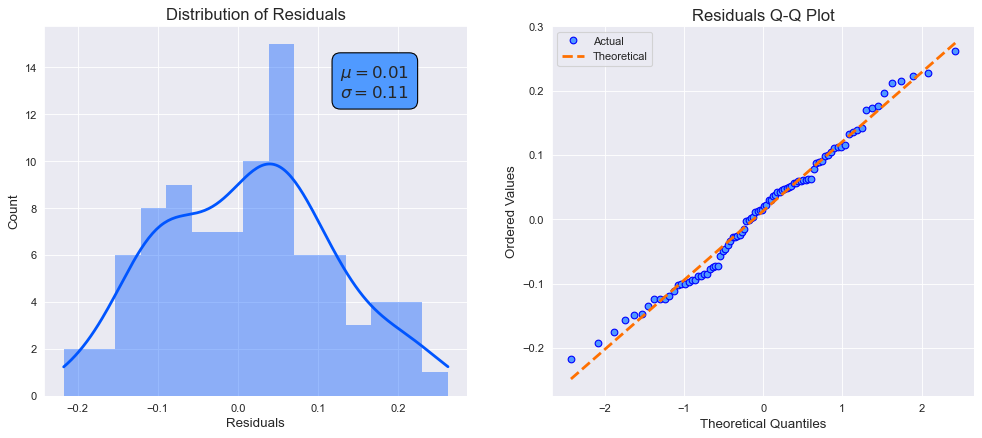

In [67]:
normal_errors_assumption(polynomial_reg, X_poly_test, y_poly_test)


Step 10.7.3: Assumption 3 - No Perfect Multicollinearity¶


In [68]:
warnings.simplefilter(action='ignore')
multicollinearity_assumption(X_poly).T

33 cases of possible multicollinearity.
28 cases of definite multicollinearity.
Assumption not satisfied.


,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Owner^2,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel^2,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
vif,5900.61,1600.38,2718.65,inf,inf,inf,inf,2291.33,1982.97,2095.33,...,inf,2.91,22.29,194.47,inf,5.69,40.17,inf,139.2,inf


Step 10.7.4: Assumption 4 - No Autocorrelation of Residuals¶


In [69]:
autocorrelation_assumption(polynomial_reg, X_poly_test, y_poly_test)


Durbin-Watson: 1.836
Little to no autocorrelation. Assumption satisfied. 



Step 10.7.5: Assumption 5 - Homoscedasticity¶


The orange line should be flat:


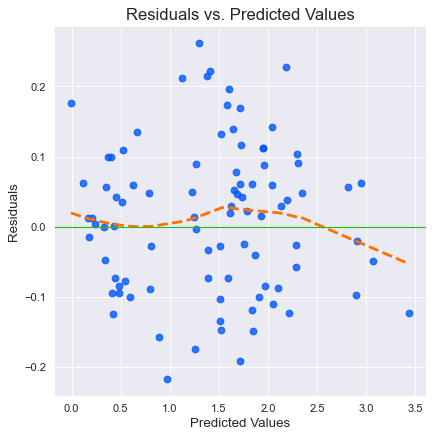

In [70]:
homoscedasticity_assumption(polynomial_reg, X_poly_test, y_poly_test)


All regression assumptions are satisfied to a good extent except for multicollinearity. But in general, the polynomial model performs better than the linear model on this data set.

To reduce multicollinearity effects we can use Regularization. Regularized regression puts contraints on the magnitude of the coefficients and will progressively shrink them towards zero relative to the least-squares estimates. There are two types of regularization as follows:

L1 Regularization or Lasso Regularization
L2 Regularization or Ridge Regularization

Step 11: Ridge Regression
In L2 Regularization or Ridge Regularization, we add a penalty which is the sum of the squared values of weights on the loss function in order to push the estimated coefficients towards zero and not take more extreme values:

Loss function = OLS + alpha * (the sum of the square of coefficients)
In the above loss function, alpha is the tuning factor which has control over the strength of the penalty term. A small alpha value leads the model to overfit and a large alpha value leads the model to underfit. We use cross-validated ridge regression to tune alpha value:

Step 11.1: Split Dataset to Training & Test Sets¶


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)


Step 11.2: Scale Data using Standard Scaler¶


In [72]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Step 11.3: Build Ridge Regression Model¶


In [73]:
alphas = 10**np.linspace(10,-2,100)*0.5

ridge_cv_model = RidgeCV(alphas = alphas, cv = 3, scoring = 'neg_mean_squared_error')                        
ridge_cv_model.fit(X_train, y_train)

RidgeCV(alphas=array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+0...
       3.06795364e+00, 2.32079442e+00, 1.75559587e+00, 1.32804389e+00,
       1.00461650e+00, 7.59955541e-01, 5.74878498e-01, 4.34874501e-01,
       3.28966612e-01, 2.48851178e-01, 1.88246790e-01, 1.42401793e-01,
       1.07721735e-01, 8.14875417e-02, 6.16423370e-02, 4.66301673e-02,
       3.52740116e-02, 2.66834962e-02, 2.01850863e-02, 1.52692775e-02,
       1.15506485e-02, 8.73764200e-03, 6.60970574e-03, 5.00000000e-03]),
        cv=3, scoring='neg_mean_squared_error')

The alpha value that results in the smallest cross-validation MSE is:



In [74]:
ridge_cv_model.alpha_


0.06164233697210317

Step 11.4: Ridge Model Evaluation


In [75]:
model_evaluation(ridge_cv_model, X_test, y_test, 'Ridge Reg. Test')


,Ridge Reg. Test
MAE,0.088627
MSE,0.011710
RMSE,0.108213
R2-Score,0.981136


Ridge Model Performance on Training Data:



In [76]:
model_evaluation(ridge_cv_model, X_train, y_train, 'Ridge Reg. Train')


,Ridge Reg. Train
MAE,0.065017
MSE,0.006550
RMSE,0.080929
R2-Score,0.987961


The accuracy of the model on the training and test data are close to each other, so the model is not overfit.
The Ridge model has almost the same accuracy as the polynomial model.

Step 11.5: Ridge Regression Coefficients¶


The Ridge Regression coefficients are:



In [77]:
ridge_cv_model.coef_


array([ 0.36609183,  0.94219762,  0.09864623,  0.02309365, -0.07519781,
       -0.11418703, -0.06460863, -0.35432223, -0.43584563, -0.1923328 ,
        0.16766332,  0.03133492, -0.05567052,  0.05302022, -0.02505909,
       -0.05810145, -0.06927462,  0.15954693,  0.07028801,  0.14433495,
        0.01641319, -0.03374477,  0.07765899,  0.04524194, -0.02998582,
        0.02309365, -0.01012408, -0.08092617, -0.07668233, -0.07519781,
       -0.00316941, -0.03175677, -0.11418703,  0.11123274, -0.06460863])

As can be seen, L2 regularization allows weights to decay towards zero but not to zero.



Step 11.6: Ridge Model Assumptions Investigation


Step 11.6.1: Assumption 1 - Linearity¶


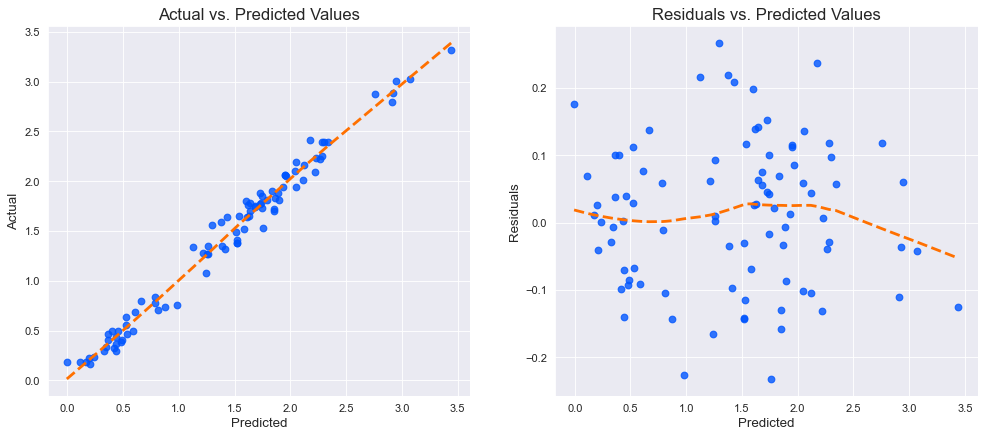

In [78]:
linear_assumption(ridge_cv_model, X_test, y_test)


Step 11.6.2: Assumption 2 - Normality of Residuals



P-value from the test (below 0.05 generally means non-normal):   0.637709
Residuals are normally distributed. Assumption satisfied.


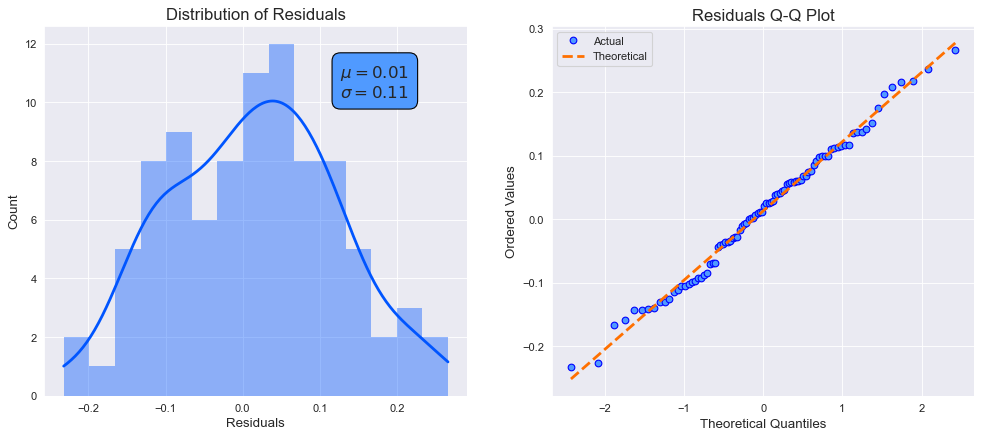

In [79]:
normal_errors_assumption(ridge_cv_model, X_test, y_test)


In [80]:
multicollinearity_assumption(X_poly).T


33 cases of possible multicollinearity.
28 cases of definite multicollinearity.
Assumption not satisfied.


,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Owner^2,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel^2,Fuel_Type_Diesel Seller_Type_Individual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Seller_Type_Individual Transmission_Manual,Transmission_Manual^2
vif,5900.61,1600.38,2718.65,inf,inf,inf,inf,2291.33,1982.97,2095.33,...,inf,2.91,22.29,194.47,inf,5.69,40.17,inf,139.2,inf


In [81]:
autocorrelation_assumption(ridge_cv_model, X_test, y_test)


Durbin-Watson: 1.749
Little to no autocorrelation. Assumption satisfied. 



The orange line should be flat:


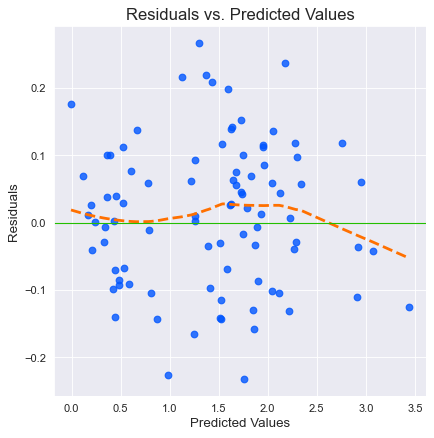

In [82]:
homoscedasticity_assumption(ridge_cv_model, X_test, y_test)


As can be seen, the assumptions have improved slightly compared to the polynomial model.¶


Step 12: Lasso Regression


In L1 Regularization or Lasso Regularization, we add a penalty which is the sum of the absolute values of weights on the loss function in order to push the estimated coefficients towards zero:

Loss function = OLS + alpha * (the sum of the absolute of coefficients)
We again use cross-validated lasso regression to tune alpha value:



Step 12.1: Build Lasso Regression Model¶


In [83]:
lasso_cv_model = LassoCV(eps=0.01, n_alphas=100, max_iter=10000, cv=3)


In [84]:
lasso_cv_model.fit(X_train, y_train)


LassoCV(cv=3, eps=0.01, max_iter=10000)

In [85]:
lasso_cv_model.alpha_


0.006881979800721571

Step 12.2: Lasso Model Evaluation on Test Data


In [86]:
model_evaluation(lasso_cv_model, X_test, y_test, 'Lasso Reg. Test')


,Lasso Reg. Test
MAE,0.116568
MSE,0.021042
RMSE,0.145059
R2-Score,0.966102


In [87]:
model_evaluation(lasso_cv_model, X_train, y_train, 'Lasso Reg. Train')


,Lasso Reg. Train
MAE,0.097111
MSE,0.014366
RMSE,0.119859
R2-Score,0.973592


The accuracy of the model on the training and test data are close to each other, so the model is not overfit.
The accuracy of the Lasso model has decreased slightly compared to the ridge model.

Step 12.3: Lasso Regression Coefficients


In [88]:
lasso_coef = lasso_cv_model.coef_
lasso_coef

array([-0.        ,  0.60294926,  0.        , -0.        ,  0.        ,
       -0.10480454,  0.        , -0.11685201, -0.01226402, -0.10880579,
       -0.        ,  0.        ,  0.        ,  0.00765437,  0.        ,
       -0.        , -0.00784492,  0.07983492, -0.        ,  0.0062655 ,
       -0.        , -0.        ,  0.        ,  0.03806997,  0.01202733,
       -0.        , -0.        , -0.00863018,  0.00189986,  0.        ,
        0.01417074, -0.        , -0.03844947, -0.        ,  0.        ])

In [89]:
lasso_coef = pd.DataFrame(lasso_cv_model.coef_, index=X_poly.columns, columns=['Lasso Coef.'])
lasso_coef = lasso_coef[lasso_coef['Lasso Coef.']!=0]
lasso_coef.T

,Present_Price,Seller_Type_Individual,Age^2,Age Present_Price,Age Kms_Driven,Age Transmission_Manual,Present_Price Owner,Present_Price Fuel_Type_Diesel,Present_Price Transmission_Manual,Kms_Driven Seller_Type_Individual,Kms_Driven Transmission_Manual,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel Seller_Type_Individual,Seller_Type_Individual^2
Lasso Coef.,0.602949,-0.104805,-0.116852,-0.012264,-0.108806,0.007654,-0.007845,0.079835,0.006265,0.03807,0.012027,-0.00863,0.0019,0.014171,-0.038449


L1 regularization allows weights to decay to zero.
In exchange for reducing the number of features from 35 to 15, the R2-score of the model has decreased from %98.16 to %96.61.

Step 12.4: Lasso Model Assumptions Investigation
Step 12.4.1: Assumption 1 - Linearity

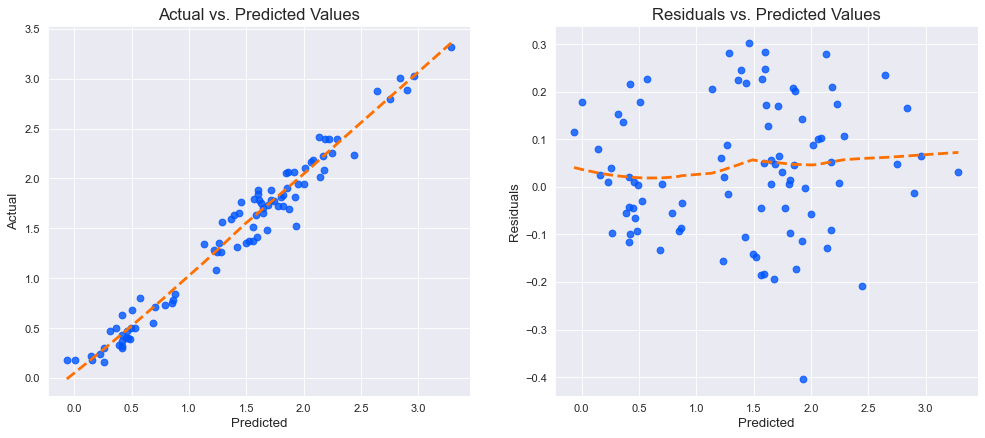

In [90]:
linear_assumption(lasso_cv_model, X_test, y_test)


Step 12.4.2: Assumption 2 - Normality of Residuals¶



P-value from the test (below 0.05 generally means non-normal):   0.259964
Residuals are normally distributed. Assumption satisfied.


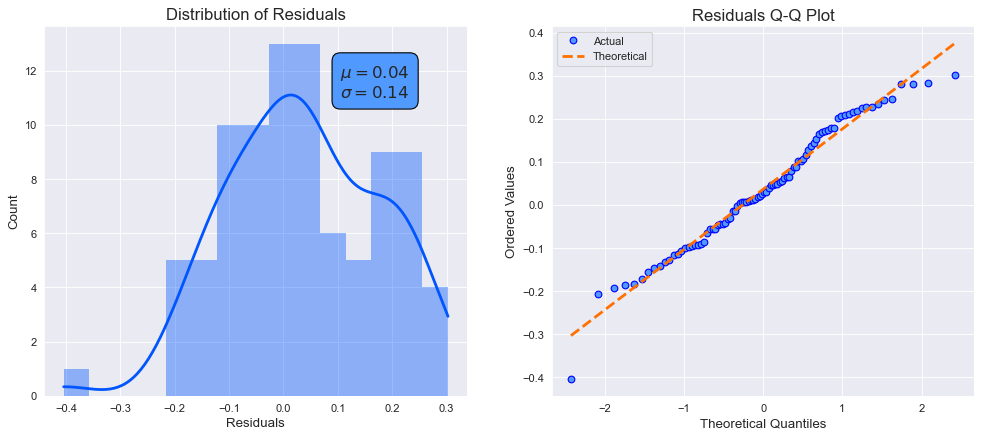

In [91]:
normal_errors_assumption(lasso_cv_model, X_test, y_test)


Step 12.4.3: Assumption 3 - No Perfect Multicollinearity


In [92]:
multicollinearity_assumption(X_poly[lasso_coef.index]).T


10 cases of possible multicollinearity.
7 cases of definite multicollinearity.
Assumption not satisfied.


,Present_Price,Seller_Type_Individual,Age^2,Age Present_Price,Age Kms_Driven,Age Transmission_Manual,Present_Price Owner,Present_Price Fuel_Type_Diesel,Present_Price Transmission_Manual,Kms_Driven Seller_Type_Individual,Kms_Driven Transmission_Manual,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel Seller_Type_Individual,Seller_Type_Individual^2
vif,64.45,inf,116.57,143.28,190.08,110.44,2.4,1.93,35.95,17.66,153.83,2.45,3.78,1.4,inf


Step 12.4.4: Assumption 4 - No Autocorrelation of Residuals¶


In [93]:
autocorrelation_assumption(lasso_cv_model, X_test, y_test)


Durbin-Watson: 1.727
Little to no autocorrelation. Assumption satisfied. 



Step 12.4.5: Assumption 5 - Homoscedasticity¶


The orange line should be flat:


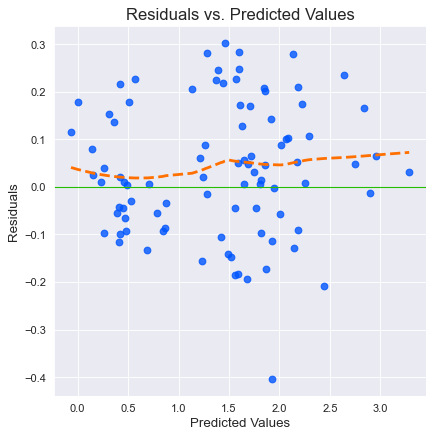

In [94]:
homoscedasticity_assumption(lasso_cv_model, X_test, y_test)


Step 13: Elastic-Net Regression¶
Elastic-Net allows a balance of both L1 and L2 penalties, which can result in better performance than a model with either one or the other penalty on problems.

Loss function = OLS + [ alpha l1_ratio L1-norm ] + [ 0.5 alpha (1 - l1_ratio) * L2-norm ]
In addition to setting an alpha value, Elastic-Net also allows us to tune the l1-ratio parameter where l1-ratio = 0 corresponds to ridge and l1-ratio = 1 corresponds to lasso. We again use cross-validated Elastic-Net regression to tune hyperparameters:

In [95]:
elastic_cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, .998, 1], 
                                eps=0.001, n_alphas=100, cv=3, max_iter=100000)

In [96]:
elastic_cv_model.fit(X_train, y_train)


ElasticNetCV(cv=3, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 0.998, 1],
             max_iter=100000)

In [97]:
elastic_cv_model.l1_ratio_


1.0

In [98]:
elastic_cv_model.alpha_


0.001045999737177493

Step 13.2: Elastic-Net Model Evaluation


In [99]:
model_evaluation(elastic_cv_model, X_test, y_test, 'Elastic-Net Reg. Test')


,Elastic-Net Reg. Test
MAE,0.103573
MSE,0.016286
RMSE,0.127617
R2-Score,0.973764


In [100]:
model_evaluation(elastic_cv_model, X_train, y_train, 'Elastic-Net Reg. Train')


,Elastic-Net Reg. Train
MAE,0.071250
MSE,0.007932
RMSE,0.089063
R2-Score,0.985419


The accuracy of the model on the training and test data are close to each other, so the model is not overfited.
The accuracy of the Elastic-Net model has decreased slightly compared to Ridge model.


- Step 13.3: Elastic-Net Regression Coefficients
The ElasticNet Regression coefficients are:

In [101]:
elastic_coef = elastic_cv_model.coef_
elastic_coef

array([ 1.14423834e-01,  9.18371586e-01,  4.83910270e-02,  0.00000000e+00,
       -0.00000000e+00, -1.02217643e-03, -0.00000000e+00, -1.11747086e-01,
       -3.51474737e-01, -1.83650062e-01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -2.25557851e-02,  6.54871719e-02,  3.24090364e-02,  1.96962494e-02,
       -0.00000000e+00, -0.00000000e+00,  3.82600360e-02,  5.83414020e-02,
        1.56930129e-02,  0.00000000e+00, -7.63248732e-04, -3.16703405e-02,
        2.62643653e-02, -0.00000000e+00,  0.00000000e+00, -2.69529006e-02,
       -1.64939808e-01, -0.00000000e+00, -3.49448369e-03])

In [102]:
elastic_coef = pd.DataFrame(elastic_cv_model.coef_, index=X_poly.columns, columns=['ElasticNet Coef.'])
elastic_coef = elastic_coef[elastic_coef['ElasticNet Coef.']!=0]
elastic_coef.T

,Age,Present_Price,Kms_Driven,Seller_Type_Individual,Age^2,Age Present_Price,Age Kms_Driven,Present_Price Owner,Present_Price Fuel_Type_Diesel,Present_Price Seller_Type_Individual,Present_Price Transmission_Manual,Kms_Driven Fuel_Type_Diesel,Kms_Driven Seller_Type_Individual,Kms_Driven Transmission_Manual,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Transmission_Manual^2
ElasticNet Coef.,0.114424,0.918372,0.048391,-0.001022,-0.111747,-0.351475,-0.18365,-0.022556,0.065487,0.032409,0.019696,0.03826,0.058341,0.015693,-0.000763,-0.03167,0.026264,-0.026953,-0.16494,-0.003494


Step 13.4: Elastic-Net Model Assumptions Investigation¶


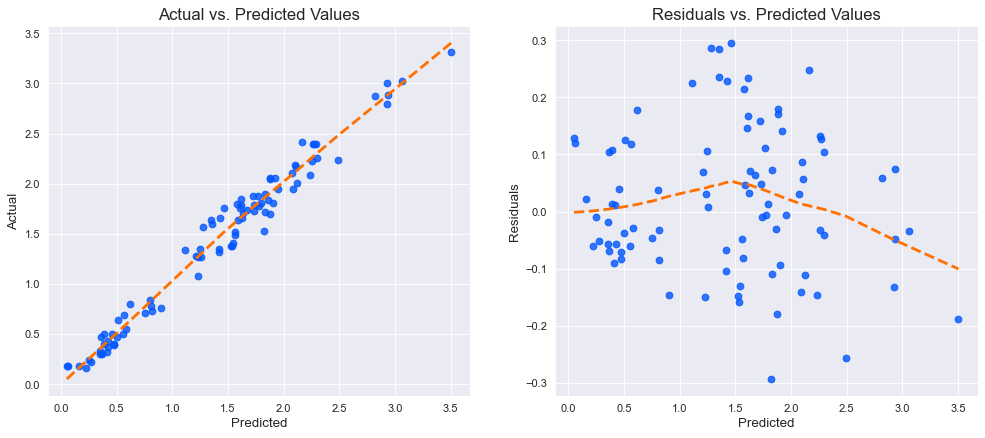

In [103]:
linear_assumption(elastic_cv_model, X_test, y_test)



P-value from the test (below 0.05 generally means non-normal):   0.527837
Residuals are normally distributed. Assumption satisfied.


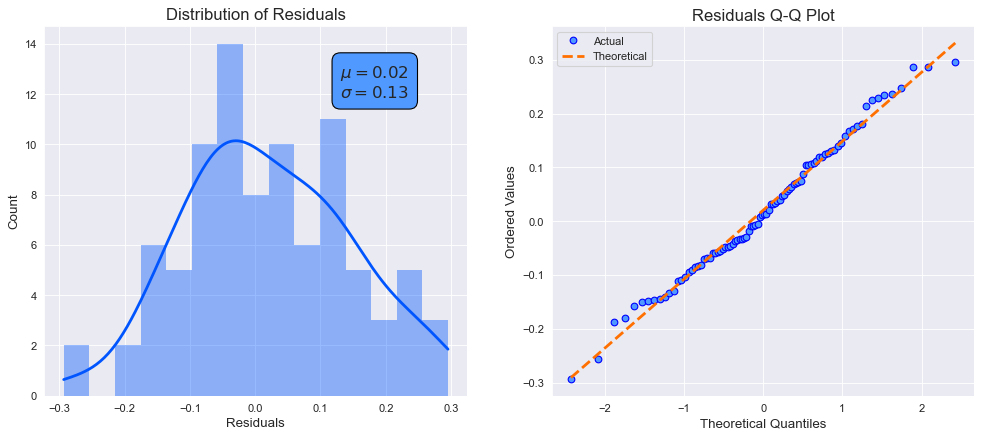

In [104]:
normal_errors_assumption(elastic_cv_model, X_test, y_test)


In [105]:
multicollinearity_assumption(X_poly[elastic_coef.index]).T


14 cases of possible multicollinearity.
9 cases of definite multicollinearity.
Assumption not satisfied.


,Age,Present_Price,Kms_Driven,Seller_Type_Individual,Age^2,Age Present_Price,Age Kms_Driven,Present_Price Owner,Present_Price Fuel_Type_Diesel,Present_Price Seller_Type_Individual,Present_Price Transmission_Manual,Kms_Driven Fuel_Type_Diesel,Kms_Driven Seller_Type_Individual,Kms_Driven Transmission_Manual,Owner Fuel_Type_Diesel,Owner Seller_Type_Individual,Owner Transmission_Manual,Fuel_Type_Diesel Transmission_Manual,Seller_Type_Individual^2,Transmission_Manual^2
vif,1480.92,262.34,908.83,inf,1055.84,242.39,829.69,2.92,27.14,7.67,54.77,33.34,24.65,111.18,1.4,2.87,4.47,9.06,inf,78.11


In [106]:


autocorrelation_assumption(elastic_cv_model, X_test, y_test)


Durbin-Watson: 1.741
Little to no autocorrelation. Assumption satisfied. 



The orange line should be flat:


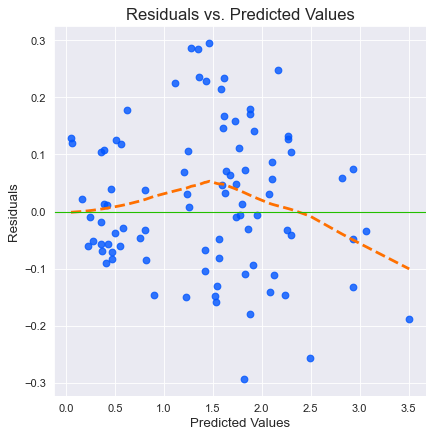

In [107]:
homoscedasticity_assumption(elastic_cv_model, X_test, y_test)


The assumptions are fulfilled to a good extent, but the accuracy of the model is lower than the ridge model.¶

- Step 14: Build Higher Order Regularized Polynomial Model

Model overfitting occurs when the model learns well from train data, so it performs worst on the test data or any unseen data provided. One of the ways to avoid overfitting is to use regularization. In the overfit model, the coefficients are generally inflated. Regularization adds a penalty to the coefficients of the model and prevents them from being heavy. Therefore, when we use regularized regression models including ridge, lasso and elastic-net, it is possible to use higher order features in the model structure.

Step 14.1: Investigating Higher Order Regularized Polynomial Models¶


The following function produces high-order features from the 2nd order to the desired order and trains and evaluates regularized models on the set of features of each order and then it returns the r2-score and the number of features used by each regularized model in the form of two separate dataframes:

In [108]:
def poly_check(degree, X, y):
    ridge_scores = []
    lasso_scores = []
    elasticnet_scores = []
    
    ridge_features = []
    lasso_features = []
    elasticnet_features = []
    
    for d in range(2,degree+1):
        poly_features = PolynomialFeatures(degree=d, include_bias=False)
        X_poly = poly_features.fit_transform(X)
        X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
        X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Ridge
        alphas = 10**np.linspace(10,-2,100)*0.5
        ridge_cv = RidgeCV(alphas = alphas, cv=3, scoring = 'neg_mean_squared_error')
        ridge_cv.fit(X_train, y_train)
        ridge_scores.append(ridge_cv.score(X_test,y_test))
        ridge_cols = ridge_cv.coef_[ridge_cv.coef_!=0].shape[0]
        ridge_features.append(ridge_cols)
        
        # Lasso
        lasso_cv = LassoCV(eps=0.01, n_alphas=100, max_iter=10000, cv=3)
        lasso_cv.fit(X_train, y_train)
        lasso_scores.append(lasso_cv.score(X_test,y_test))
        lasso_cols = lasso_cv.coef_[lasso_cv.coef_!=0].shape[0]
        lasso_features.append(lasso_cols)
        
        # Elastic-Net
        elastic_cv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, cv=3, max_iter=100000)
        elastic_cv.fit(X_train, y_train)
        elasticnet_scores.append(elastic_cv.score(X_test,y_test))
        elasticnet_cols = elastic_cv.coef_[elastic_cv.coef_!=0].shape[0]
        elasticnet_features.append(elasticnet_cols)
           
    scores = pd.DataFrame({'Ridge':ridge_scores, 'Lasso':lasso_scores, 'ElasticNet':elasticnet_scores}).round(4)
    scores = pd.concat([pd.DataFrame({'Degree':range(2,degree+1)}), scores], axis=1)  
    feature_num = pd.DataFrame({'Ridge':ridge_features, 'Lasso':lasso_features, 'ElasticNet':elasticnet_features})
    feature_num = pd.concat([pd.DataFrame({'Degree':range(2,degree+1)}), feature_num], axis=1)
    return scores, feature_num

In [109]:
scores, feature_num = poly_check(6, X, y)


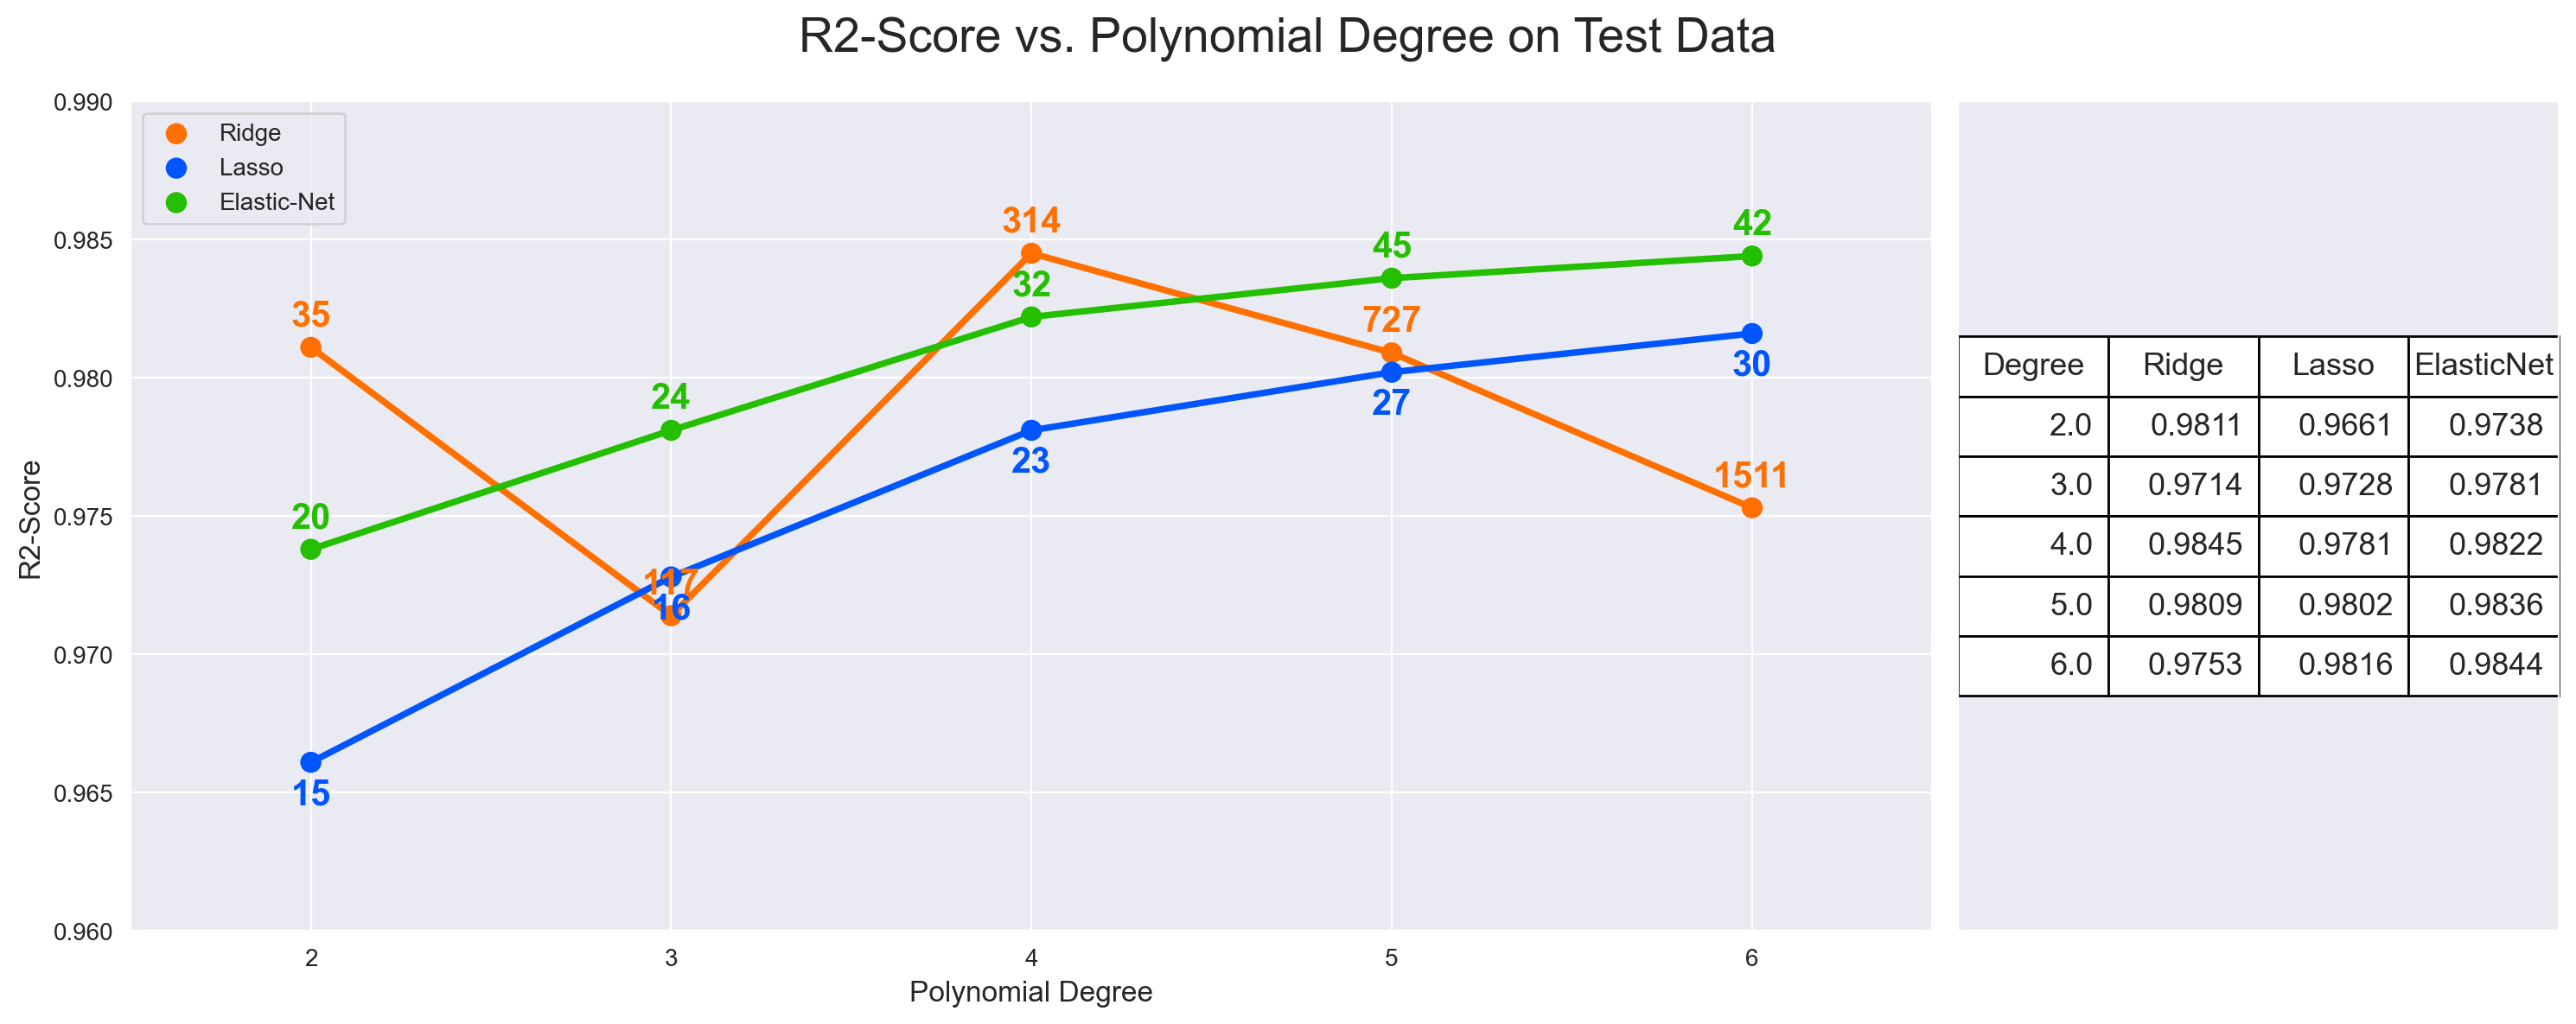

In [110]:
# Plot1
fig, ax = plt.subplots(1, 2, figsize=(15,6), dpi=200, gridspec_kw={'width_ratios': [3, 1]})

sns.pointplot(x=scores['Degree'], y=scores['Ridge'], color='#ff7000', label='Ridge', ax=ax[0])
sns.pointplot(x=scores['Degree'], y=scores['Lasso'], color='#0055ff', label='Lasso', ax=ax[0])
sns.pointplot(x=scores['Degree'], y=scores['ElasticNet'], color='#23bf00', label='Elastic-Net', ax=ax[0])
ax[0].set_xlabel('Polynomial Degree', fontsize=12)
ax[0].set_ylabel('R2-Score', fontsize=12)
ax[0].legend(loc='upper left')
ax[0].grid(axis='x')
ax[0].set_ylim([0.96, 0.99])

# Annotate Points
for i,j,f in zip(scores['Degree']-2, scores['Ridge'], feature_num['Ridge']):
    ax[0].text(i, j+0.0008, str(f), ha='center', color='#ff7000', weight='bold', fontsize=15)

for i,j,f in zip(scores['Degree']-2, scores['Lasso'], feature_num['Lasso']):
    ax[0].text(i, j-0.0015, str(f), ha='center', color='#0055ff', weight='bold', fontsize=15)
    
for i,j,f in zip(scores['Degree']-2, scores['ElasticNet'], feature_num['ElasticNet']):
    ax[0].text(i, j+0.0008, str(f), ha='center', color='#23bf00', weight='bold', fontsize=15)
    
# Plot2    
table = ax[1].table(cellText=scores.values, colLabels=scores.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(13)
ax[1].set_xticks([])
ax[1].set_yticks([])
table.scale(1, 2)

plt.suptitle('R2-Score vs. Polynomial Degree on Test Data', fontsize=20)
plt.tight_layout()
plt.show()

The graph on the left shows the trend of r2-score changes related to three regularized models including ridge, lasso and elastic-net along with the increase in the order of the used features.
The values annotated on the left graph are the number of features used in each model.
The table on the right contains r2-scores for each model.
An optimal model is one that not only uses fewer features, but also has a high r2-score.
In the situation where the simple polynomial model was overfit for the 3d-order model in the step 10, but the regularized models are not overfit for the features of orders higher than 2.

Step 14.2: Build the Optimal Model¶

Based on the previous graph, we choose the elastic-net model based on the 4th order polynomial model as the optimal model. By increasing the order from 4 onwards, the r2-score of the model is almost constant:



Step 14.2.1: Create 5th-order Polynomial Features


In [111]:
poly_features = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly = pd.DataFrame(X_poly, columns=poly_features.get_feature_names_out(X.columns))
X_poly.head()

,Age,Present_Price,Kms_Driven,Owner,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Manual,Age^2,Age Present_Price,Age Kms_Driven,...,Fuel_Type_Diesel^2 Transmission_Manual^2,Fuel_Type_Diesel Seller_Type_Individual^3,Fuel_Type_Diesel Seller_Type_Individual^2 Transmission_Manual,Fuel_Type_Diesel Seller_Type_Individual Transmission_Manual^2,Fuel_Type_Diesel Transmission_Manual^3,Seller_Type_Individual^4,Seller_Type_Individual^3 Transmission_Manual,Seller_Type_Individual^2 Transmission_Manual^2,Seller_Type_Individual Transmission_Manual^3,Transmission_Manual^4
0,1.320187,2.032688,98.846654,0.0,0.000000,0.0,1514.777352,1.742893,2.683528,130.496050,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,5.264962e+12
1,1.398824,2.587658,116.843776,0.0,0.136279,0.0,1514.777352,1.956709,3.619679,163.443905,...,42614.289158,0.0,0.0,0.0,4.736693e+08,0.0,0.0,0.0,0.0,5.264962e+12
2,0.907273,2.622591,60.223871,0.0,0.000000,0.0,1514.777352,0.823145,2.379406,54.639502,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,5.264962e+12
3,1.518024,1.749435,54.276845,0.0,0.000000,0.0,1514.777352,2.304398,2.655684,82.393575,...,0.000000,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,5.264962e+12
4,1.320187,2.240043,116.305479,0.0,0.136279,0.0,1514.777352,1.742893,2.957275,153.544961,...,42614.289158,0.0,0.0,0.0,4.736693e+08,0.0,0.0,0.0,0.0,5.264962e+12


Step 14.2.2: Split Dataset to Train & Test Sets¶


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)


In [113]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [114]:
final_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, cv=4, max_iter=100000)

In [115]:
final_model.fit(X_train, y_train)


ElasticNetCV(cv=4, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 0.995, 1],
             max_iter=100000)

In [116]:
final_model.l1_ratio_


1.0

In [117]:
final_model.alpha_


0.0006881979800721572

In [118]:
model_evaluation(final_model, X_test, y_test, 'Final Model. Test')


,Final Model. Test
MAE,0.083486
MSE,0.010573
RMSE,0.102825
R2-Score,0.982967


In [119]:
model_evaluation(final_model, X_train, y_train, 'Final Model. Train')


,Final Model. Train
MAE,0.061915
MSE,0.006108
RMSE,0.078152
R2-Score,0.988773
